In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import json

import seaborn as sns
import os
from multiprocessing import Pool
from pathlib import Path
import sys

from fuzzywuzzy import process


# set path to the utils
notebook_dir = os.getcwd()
notebook_name = "correct_return_periods.ipynb"

PATH = Path(notebook_dir) / Path(notebook_name) 

sys.path.insert(0, str(Path(*[i for i in PATH.parts[:PATH.parts.index("VIEWS_FAO_index")+1]]) / "src/utils"))   

from set_paths import setup_project_paths, get_logo_path, get_data_paths, setup_root_paths, get_plot_path
setup_project_paths(PATH)


from utils_plotting import plot_country_time_series #, plot_random_monthly_and_yearly_data, plot_feature_histograms, plot_contry_period_map
from utils_annual_aggregation import aggregate_monthly_to_yearly
from utils_feature_eng_per_100k import feature_eng_fat_per_100k
from utils_small_p_i import calculate_p_i
from utils_big_P_i import calculate_P_i

#from utils_likelihoods import calculate_likelihood_of_at_least_one_event

from utils_return_periods import calculate_return_periods

#from utils_global_probabilities import calculate_global_probabilities
#from utils_country_probabilities import calculate_all_country_probabilities
#from utils_check_expected_features import check_expected_features    
from utils_date_index import calculate_date_from_index 

#from utils_country_id_csv_to_json import country_id_csv_to_json

from utils_get_country_names_by_ids import get_country_names_by_ids
from utils_get_country_id_by_name import get_country_id_by_name
from utils_get_time_period import get_time_period

from utils_update_df_with_probabilities_and_return_periods import update_df_with_probabilities_and_return_periods

from utils_get_extended_feature_list import get_extended_feature_list

from utils_process_data_country_wise import process_data_country_wise

#from process_raw_viewser_data import process_raw_viewser_data

In [2]:
print(np.__version__) # 1.26.4 used
print(pd.__version__) # 2.2.1 used
print(matplotlib.__version__) # 3.8.4 used
print(sns.__version__) # 0.13.2 used

1.26.4
2.2.1
3.8.4
0.13.2


In [3]:
PATH_RAW_VIEWSER, PATH_RAW_EXTERNAL, PATH_PROCESSED, PATH_GENERATED = get_data_paths(PATH)

# NOW:

- you need to do somethign with main

- plot everything and anticipate aggregations by make 1x1 part of the folder struture or file name

- Maps plots! 

In [ ]:
# load the data from the pkl
df_monthly = pd.read_pickle(PATH_GENERATED / "df_monthly_country_return_periods.pkl")
df_yearly = pd.read_pickle(PATH_GENERATED / "df_yearly_country_return_periods.pkl")

In [21]:
# NEEDS TOTALS FOR ALL FAATURES

features = ['sb_best', 'ns_best', 'os_best', 'total_best',
            'pop_gpw_sum', 'total_best_per_100k_country', 
            'sb_best_per_100k_country','os_best_per_100k_country', 'ns_best_per_100k_country']

            # Can we average this in this plt? Or count the number of events? What is the best way to show this?'
            # binning might be the solution bc we can show how many 5 period events, 10 period events, etc. there are in each country over the time periods.
            #'sb_best_p_i', 'sb_best_P_i', 'sb_best_e_i', 'sb_best_E_i', 
            #'ns_best_p_i', 'ns_best_P_i', 'ns_best_e_i', 'ns_best_E_i', 
            #'os_best_p_i', 'os_best_P_i', 'os_best_e_i', 'os_best_E_i']

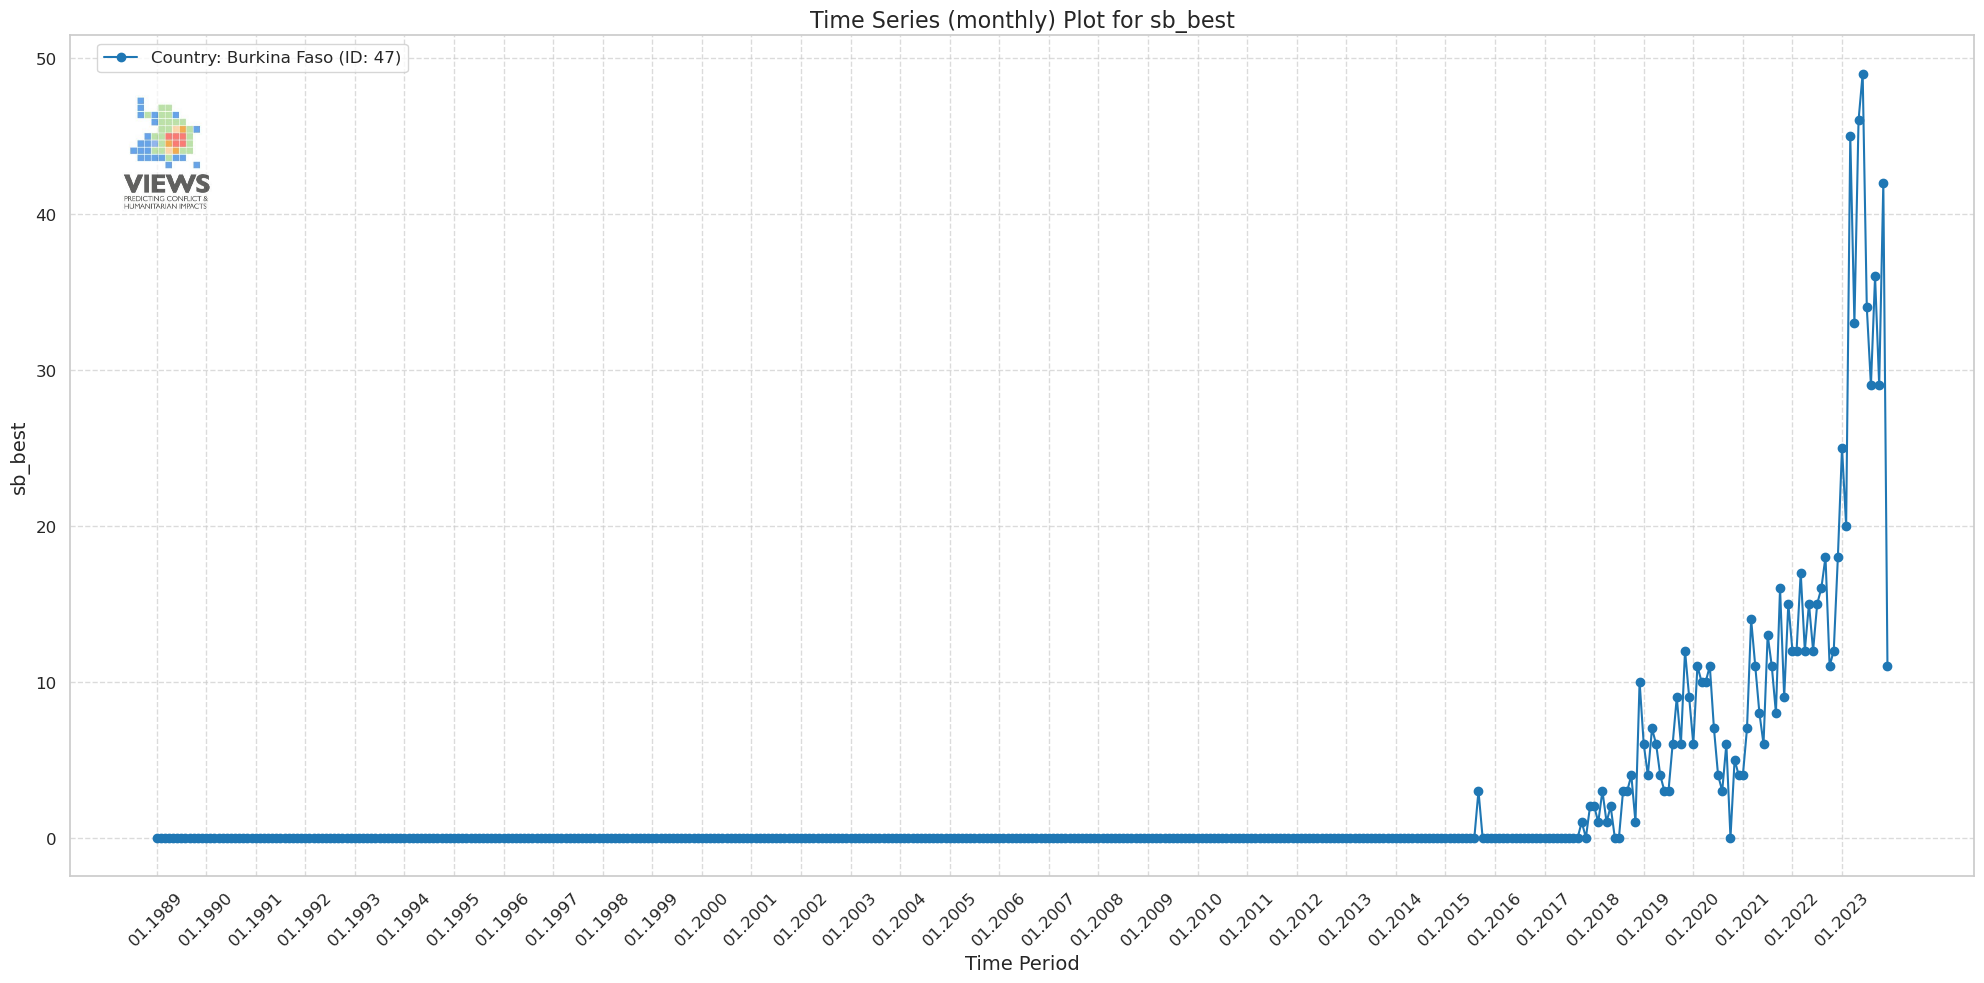

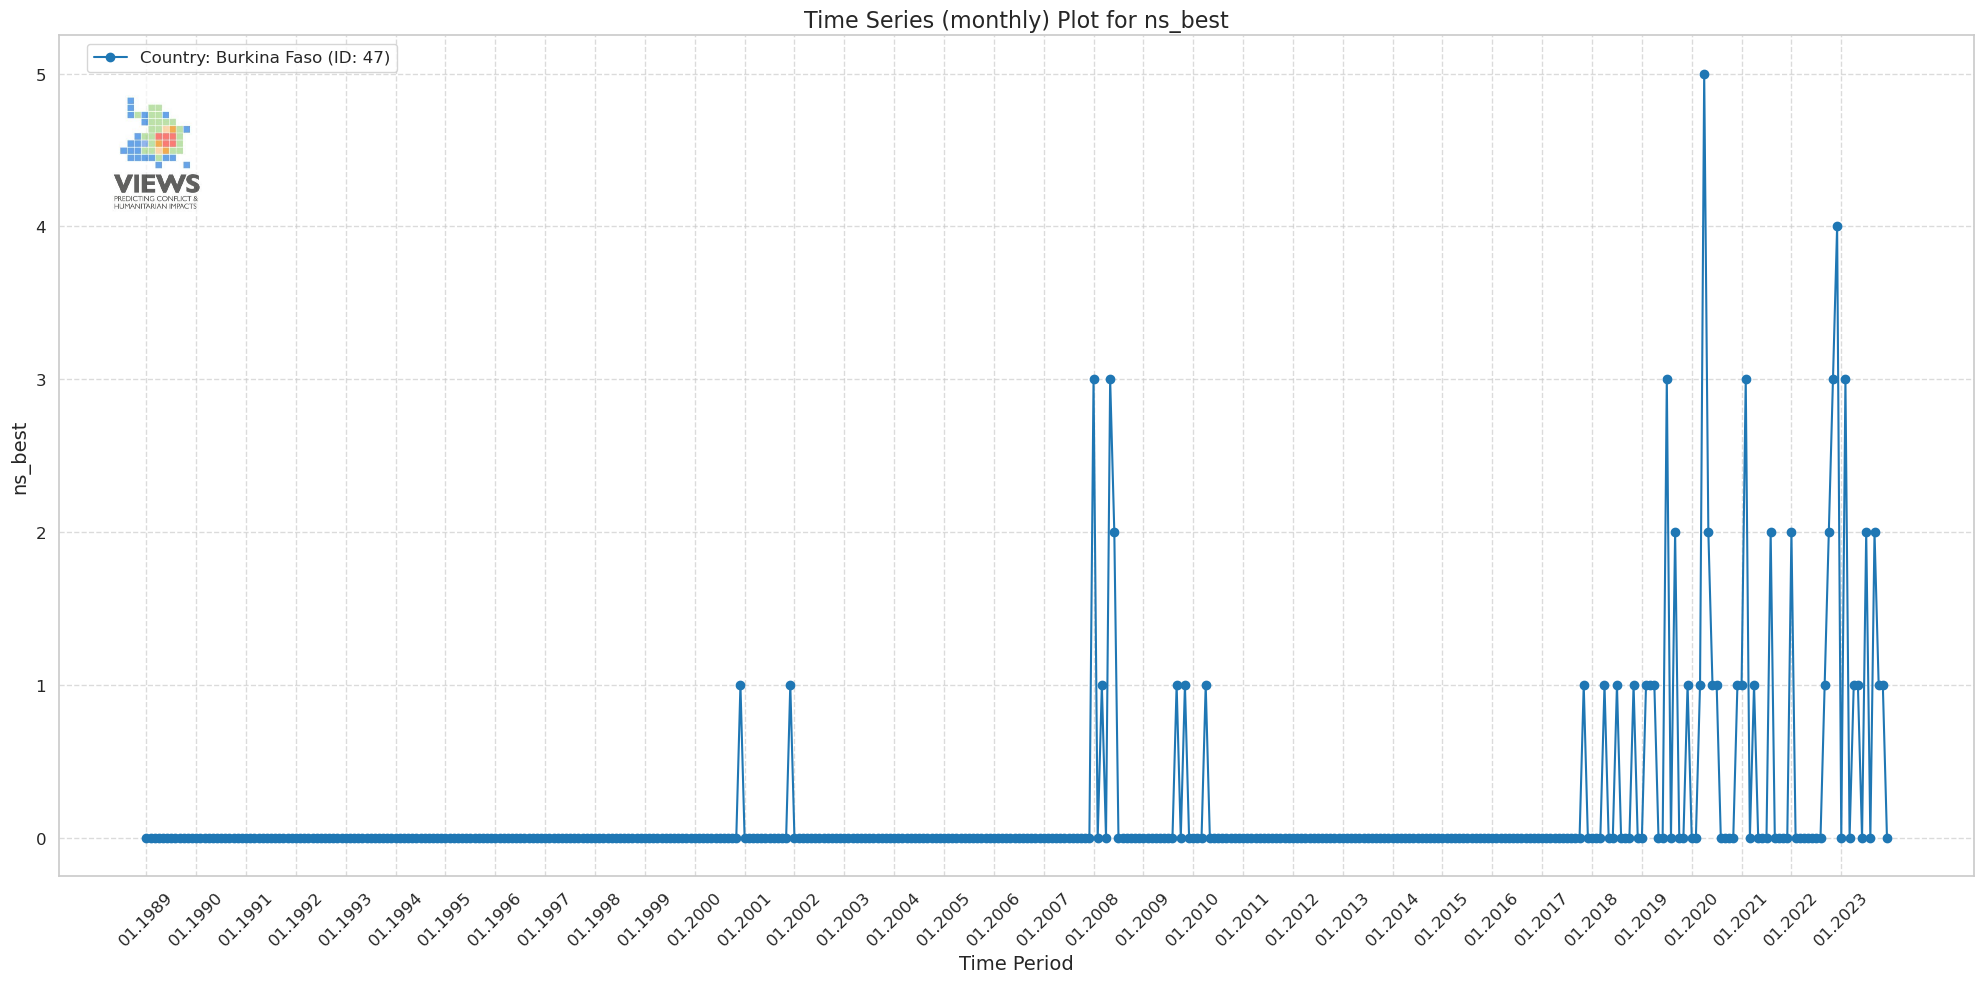

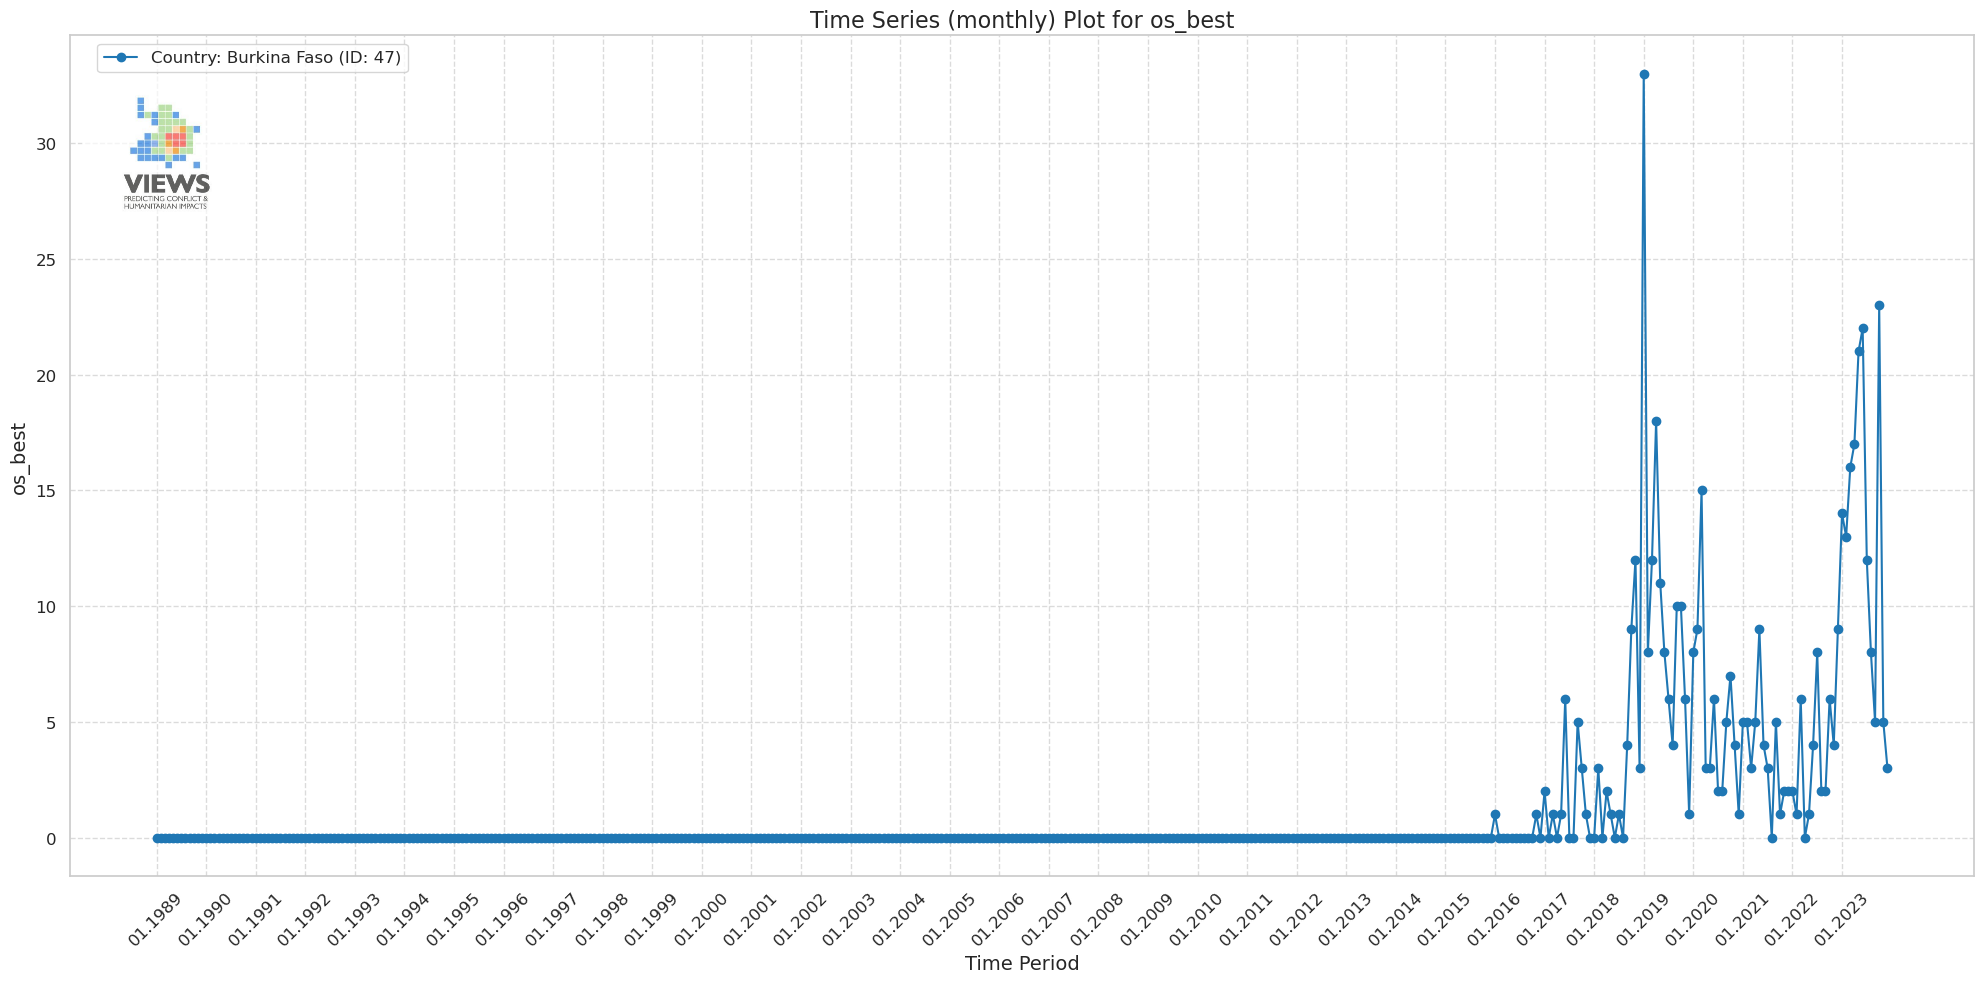

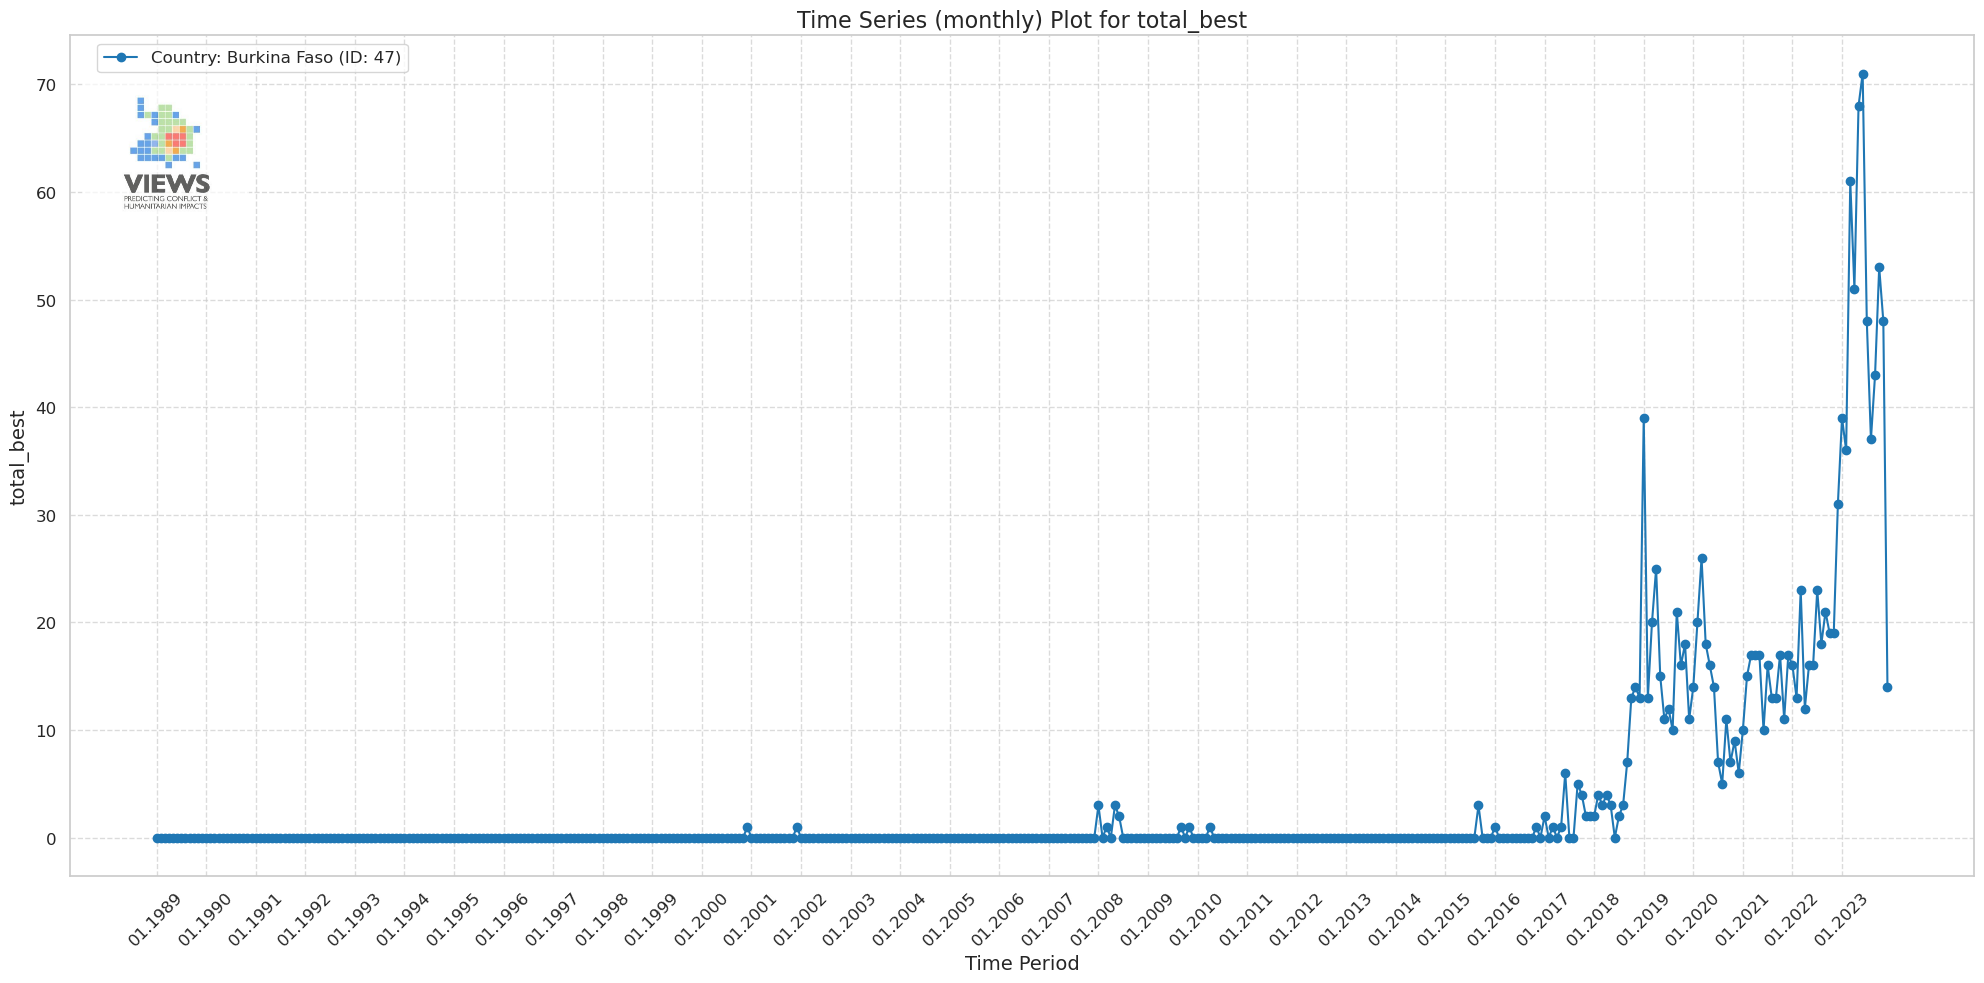

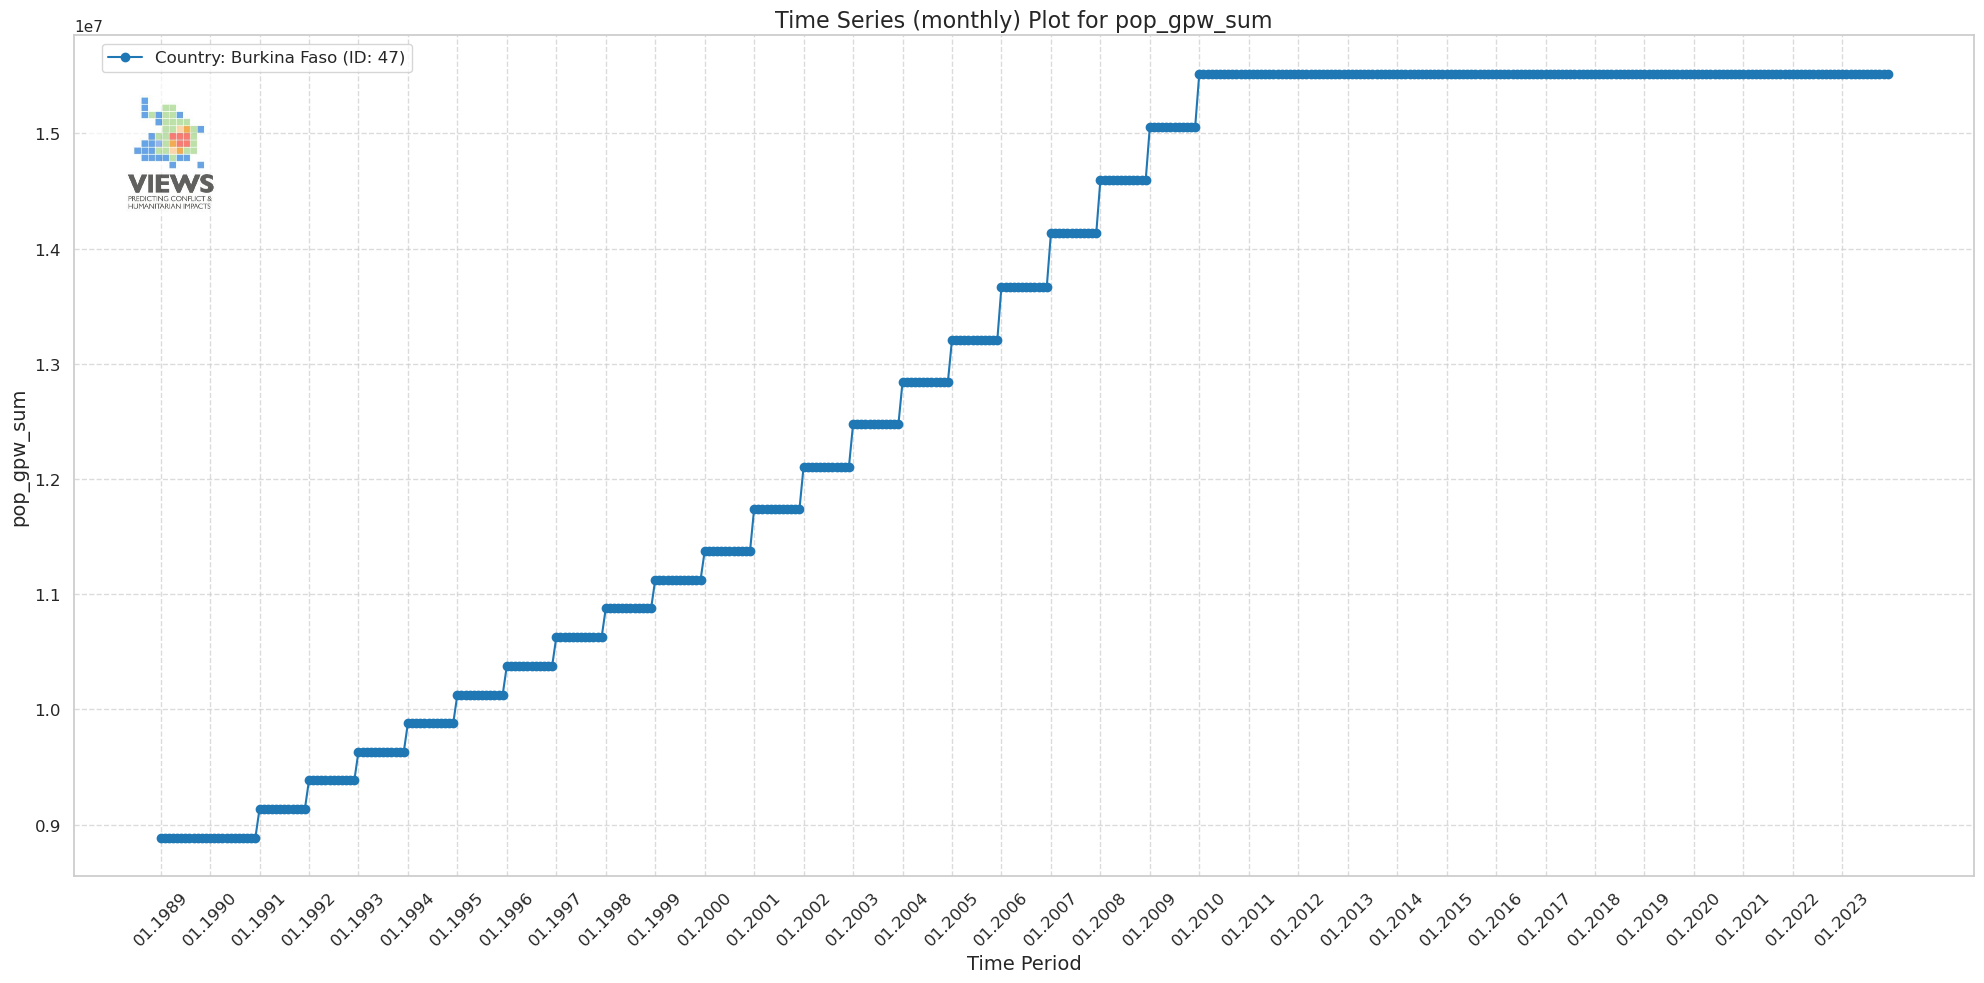

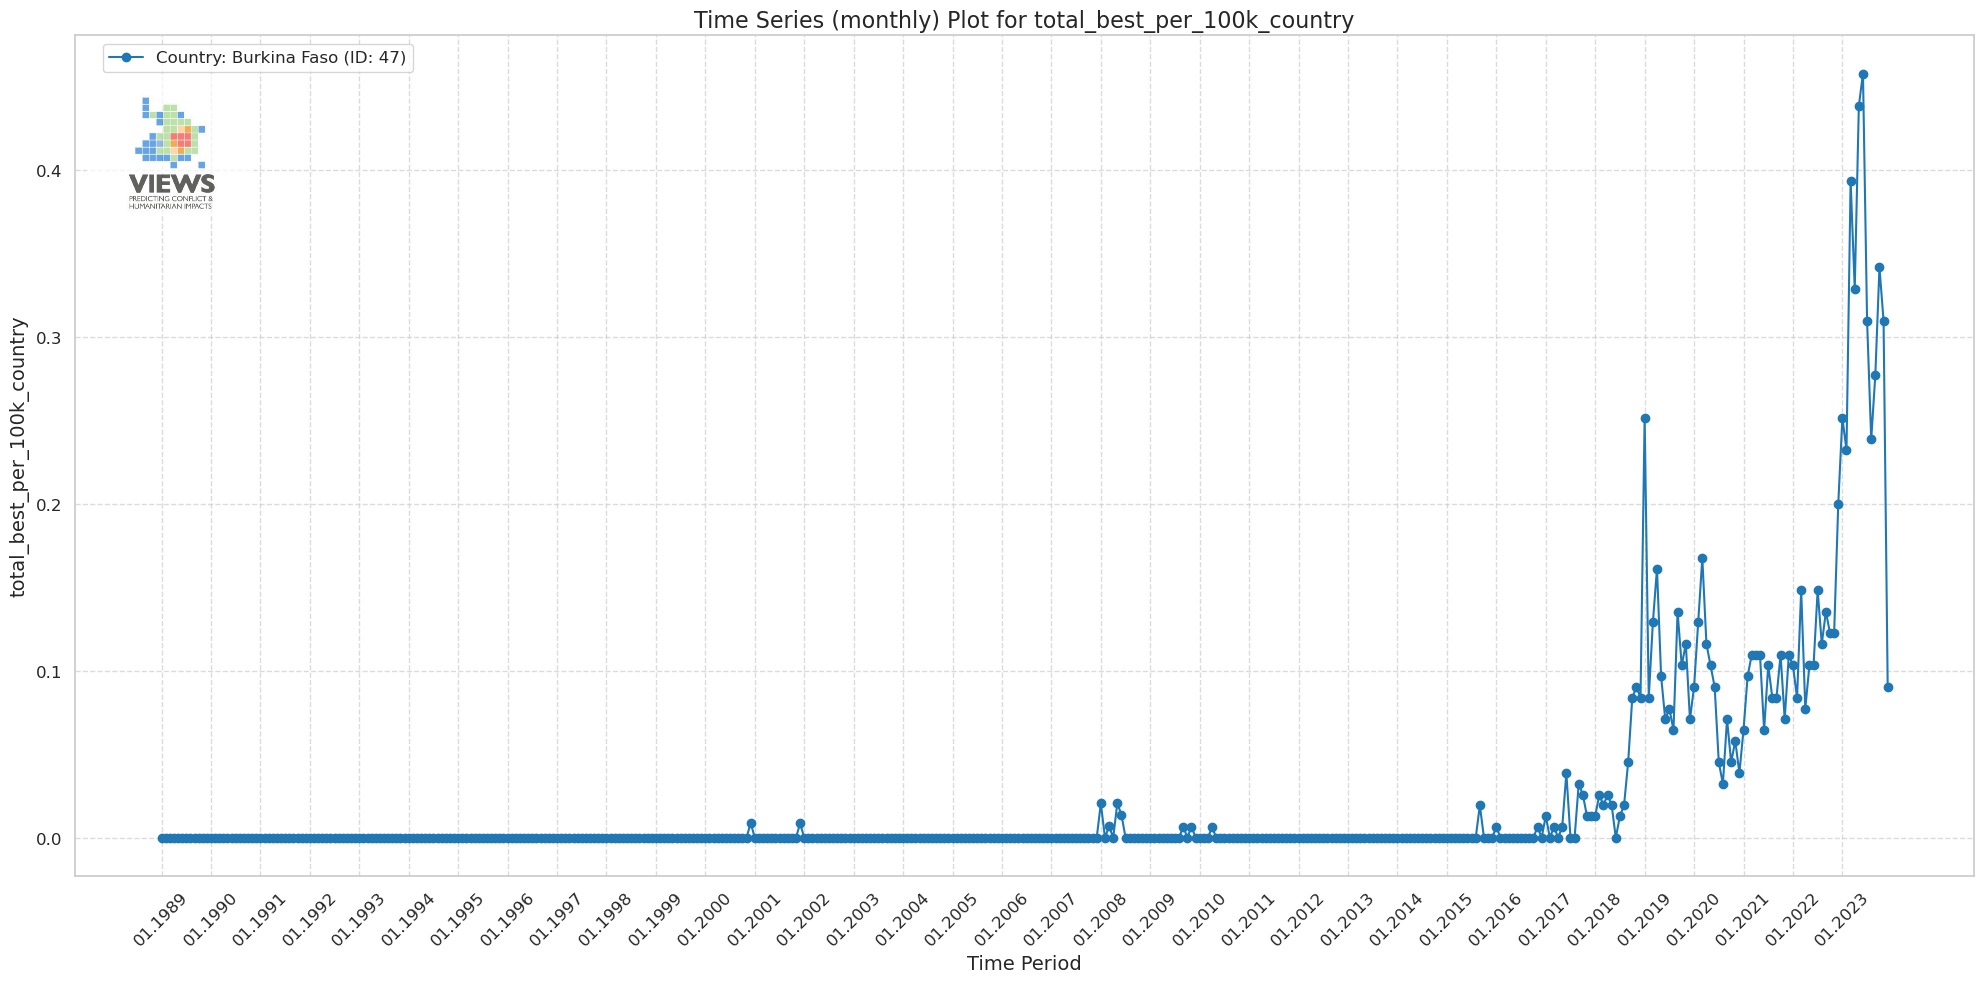

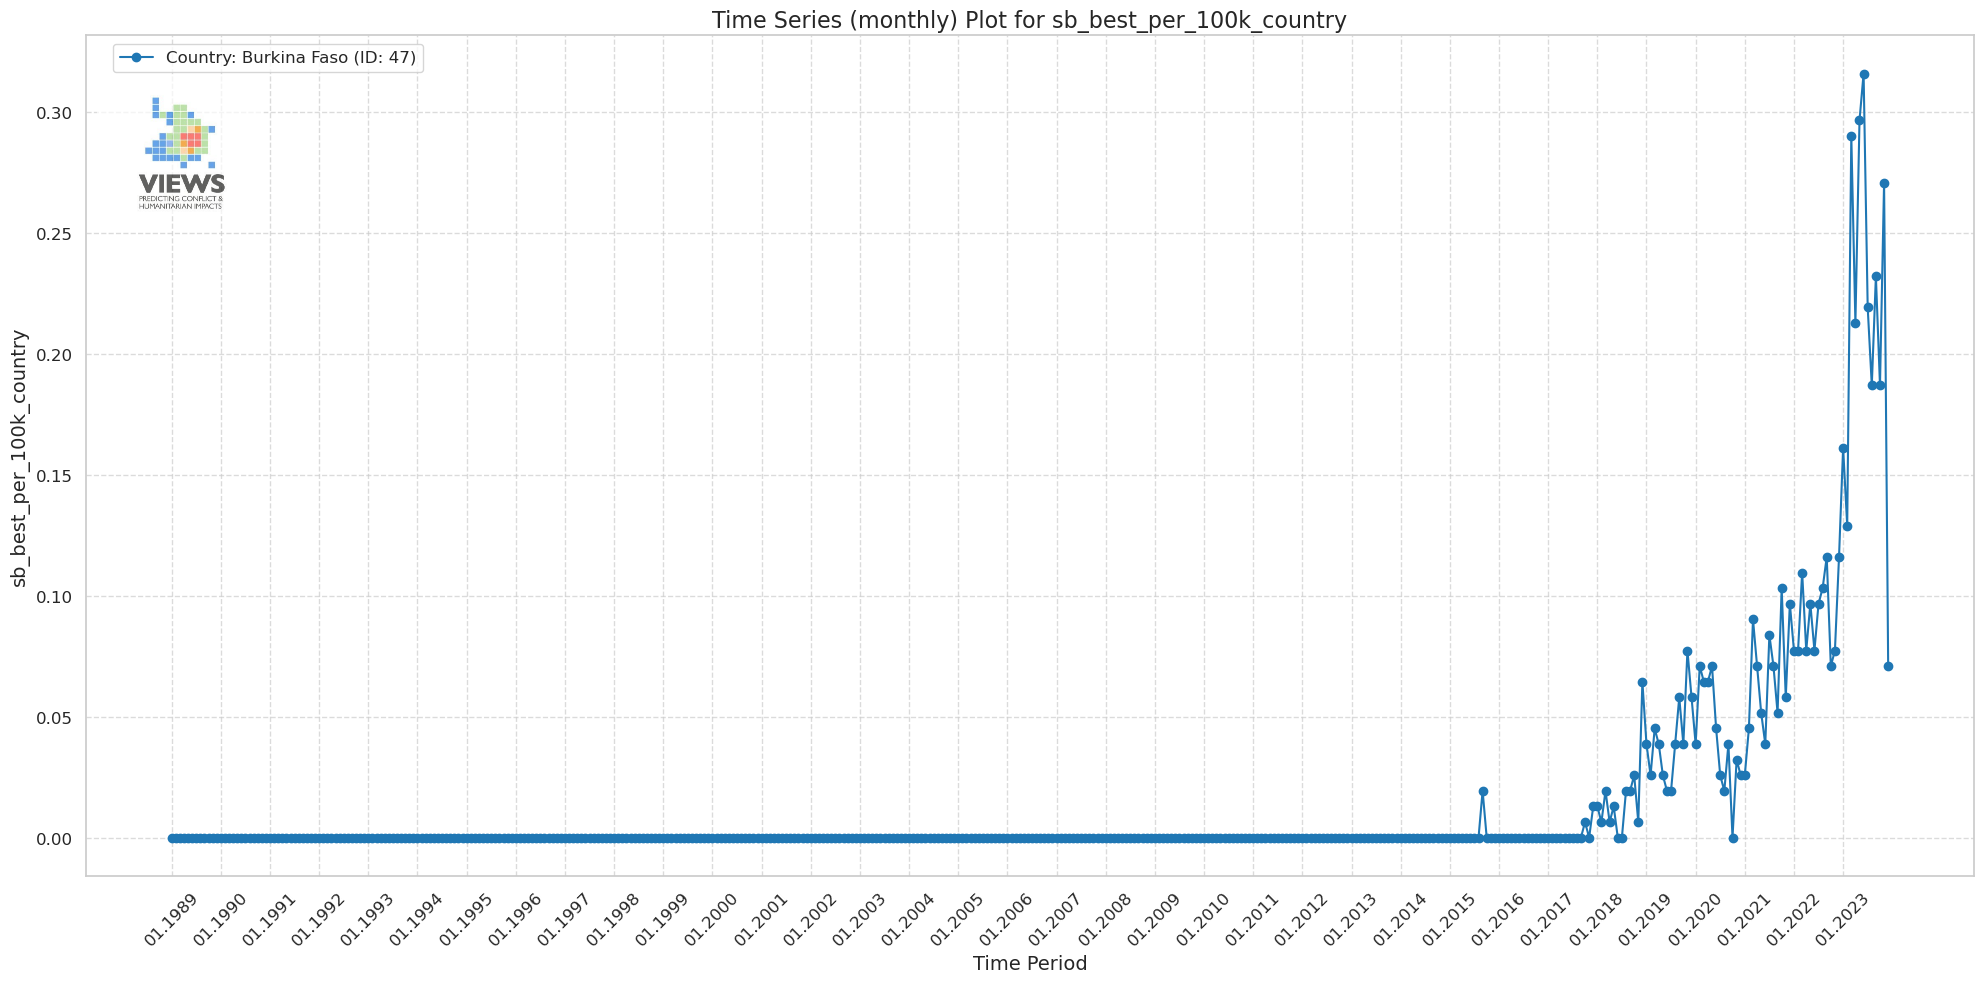

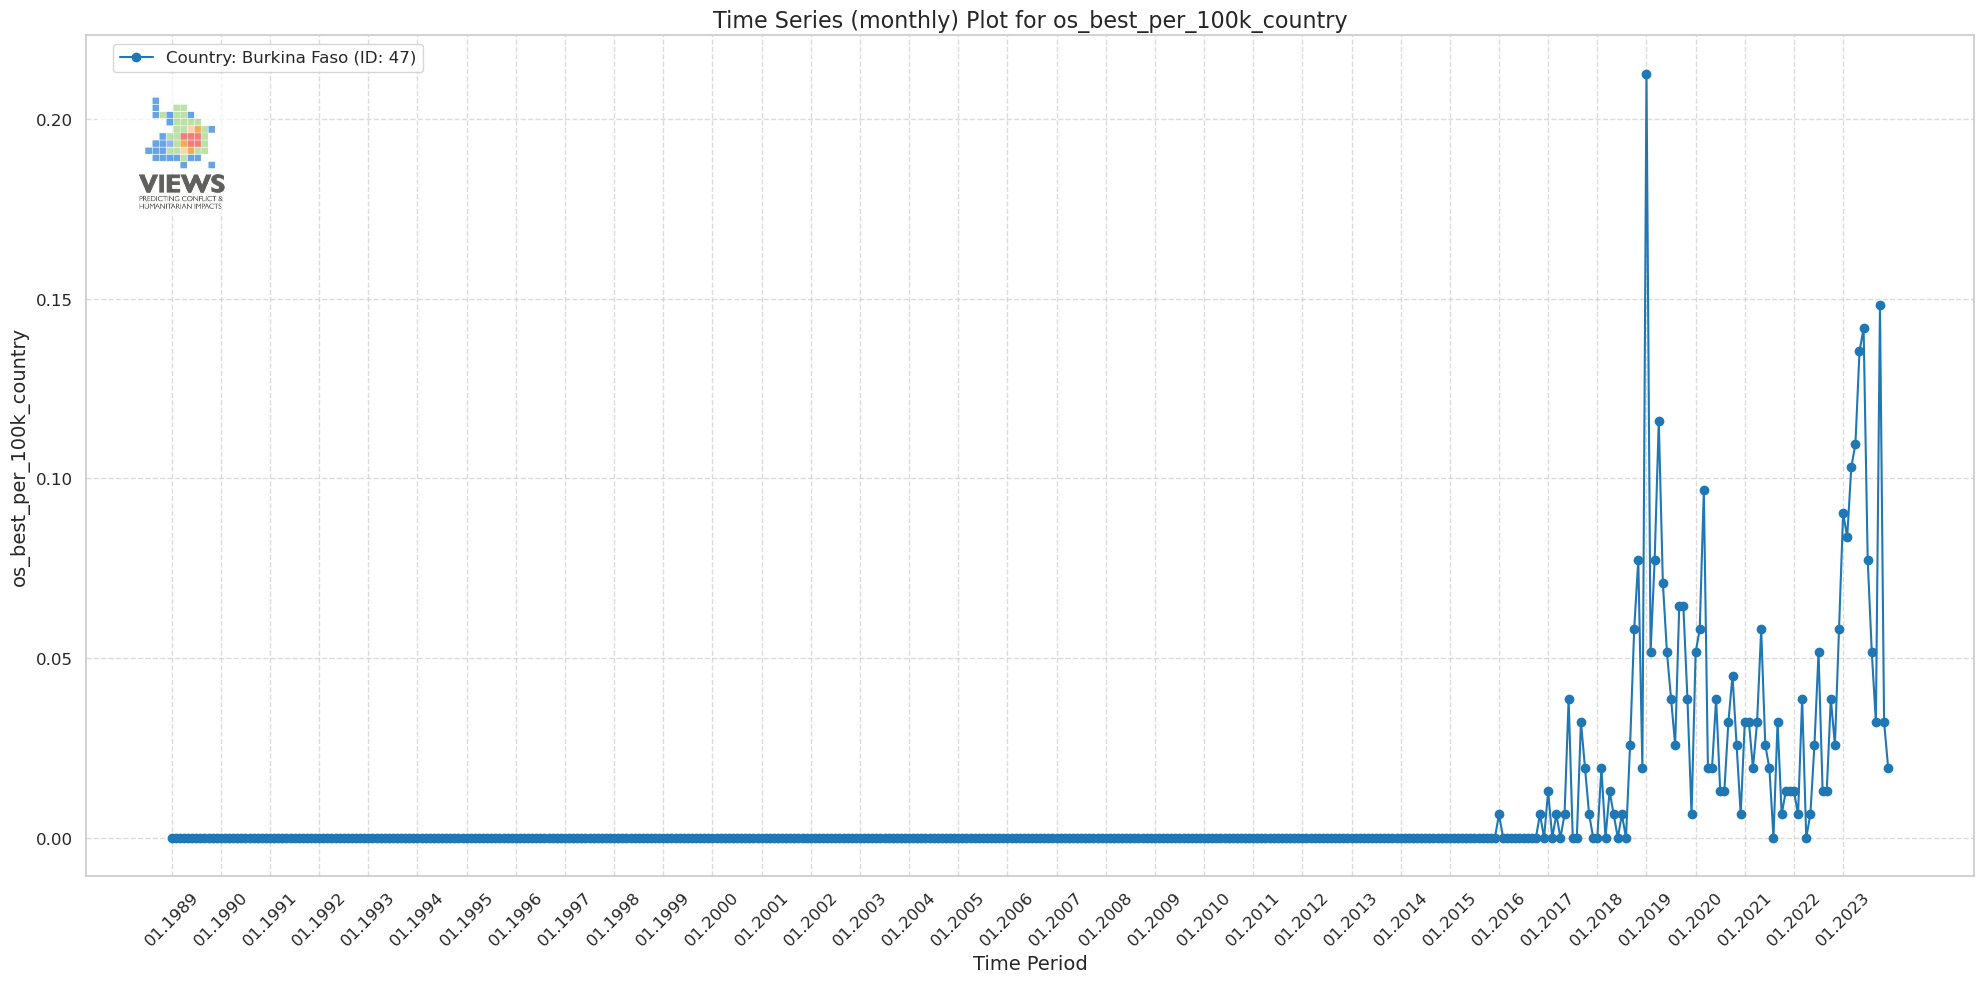

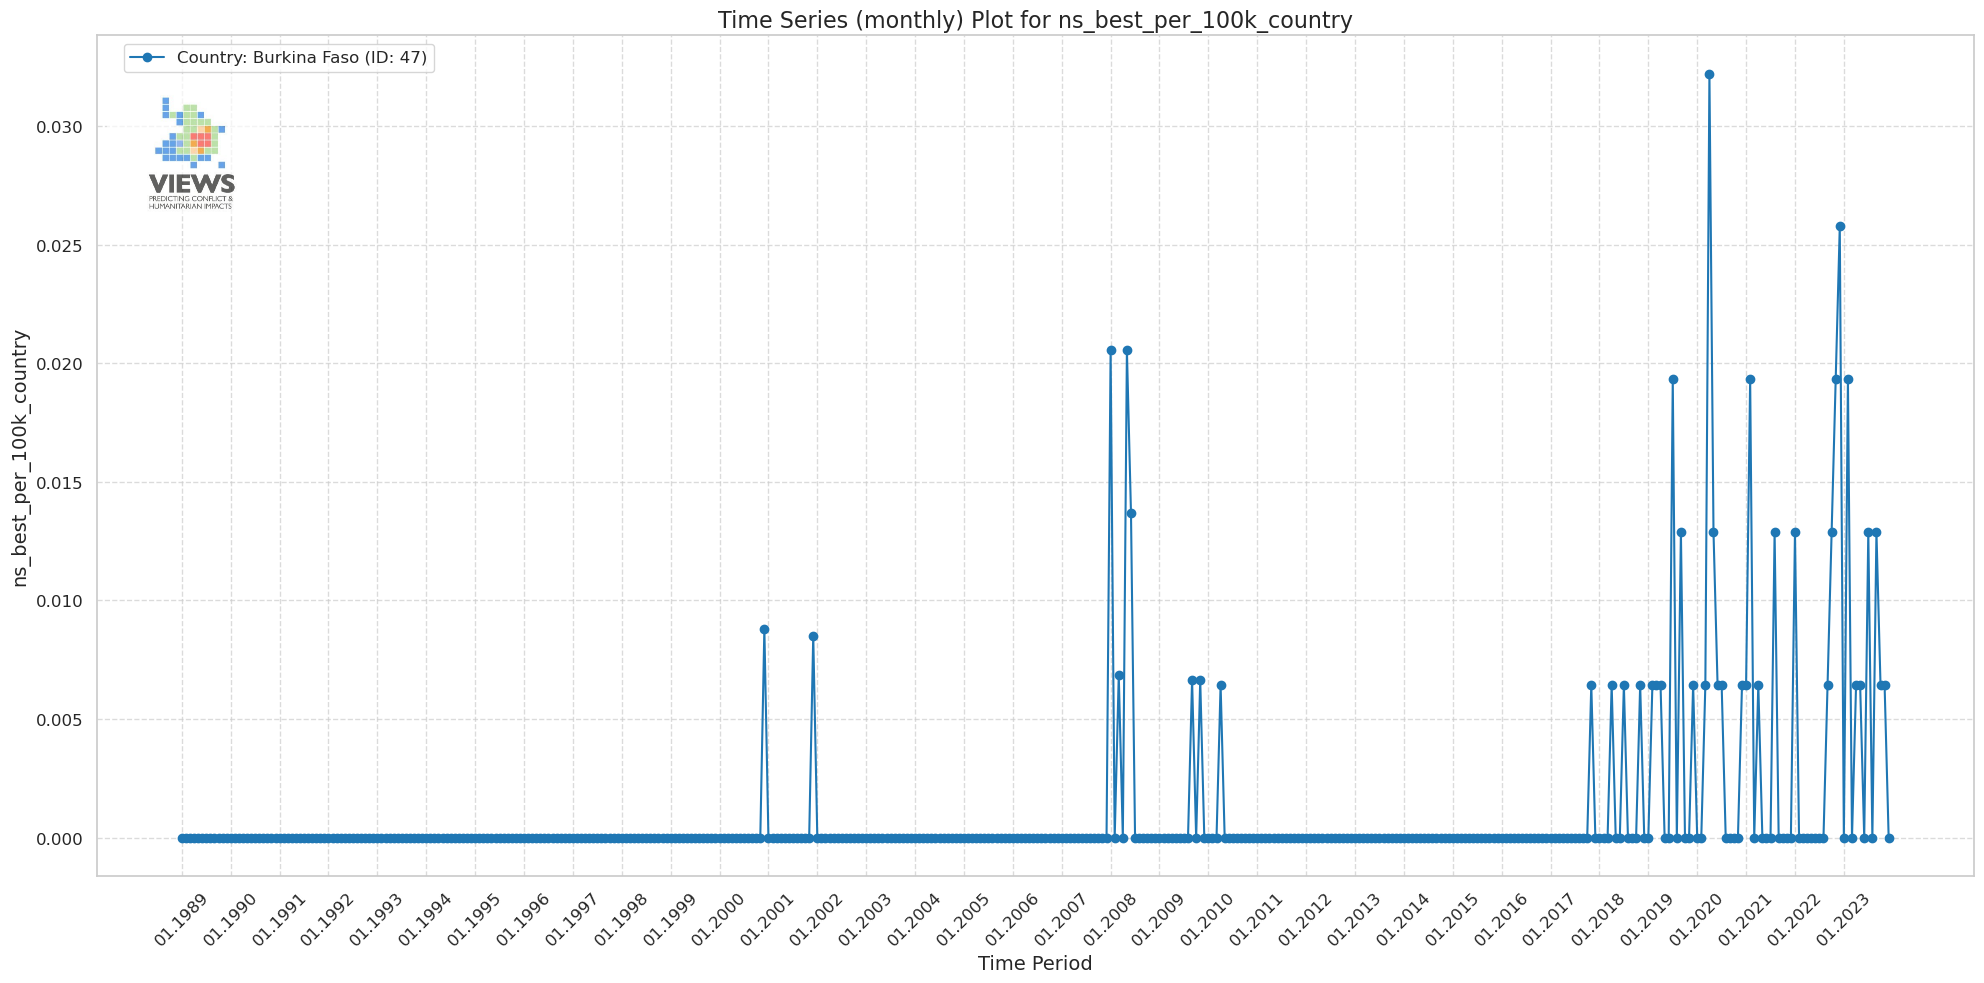

In [19]:
for feature in features:
    plot_country_time_series(df_monthly, [47], feature, figsize=(20, 10), logo_placement = (0.05, 0.87), legend_placement=(0.01, 1))

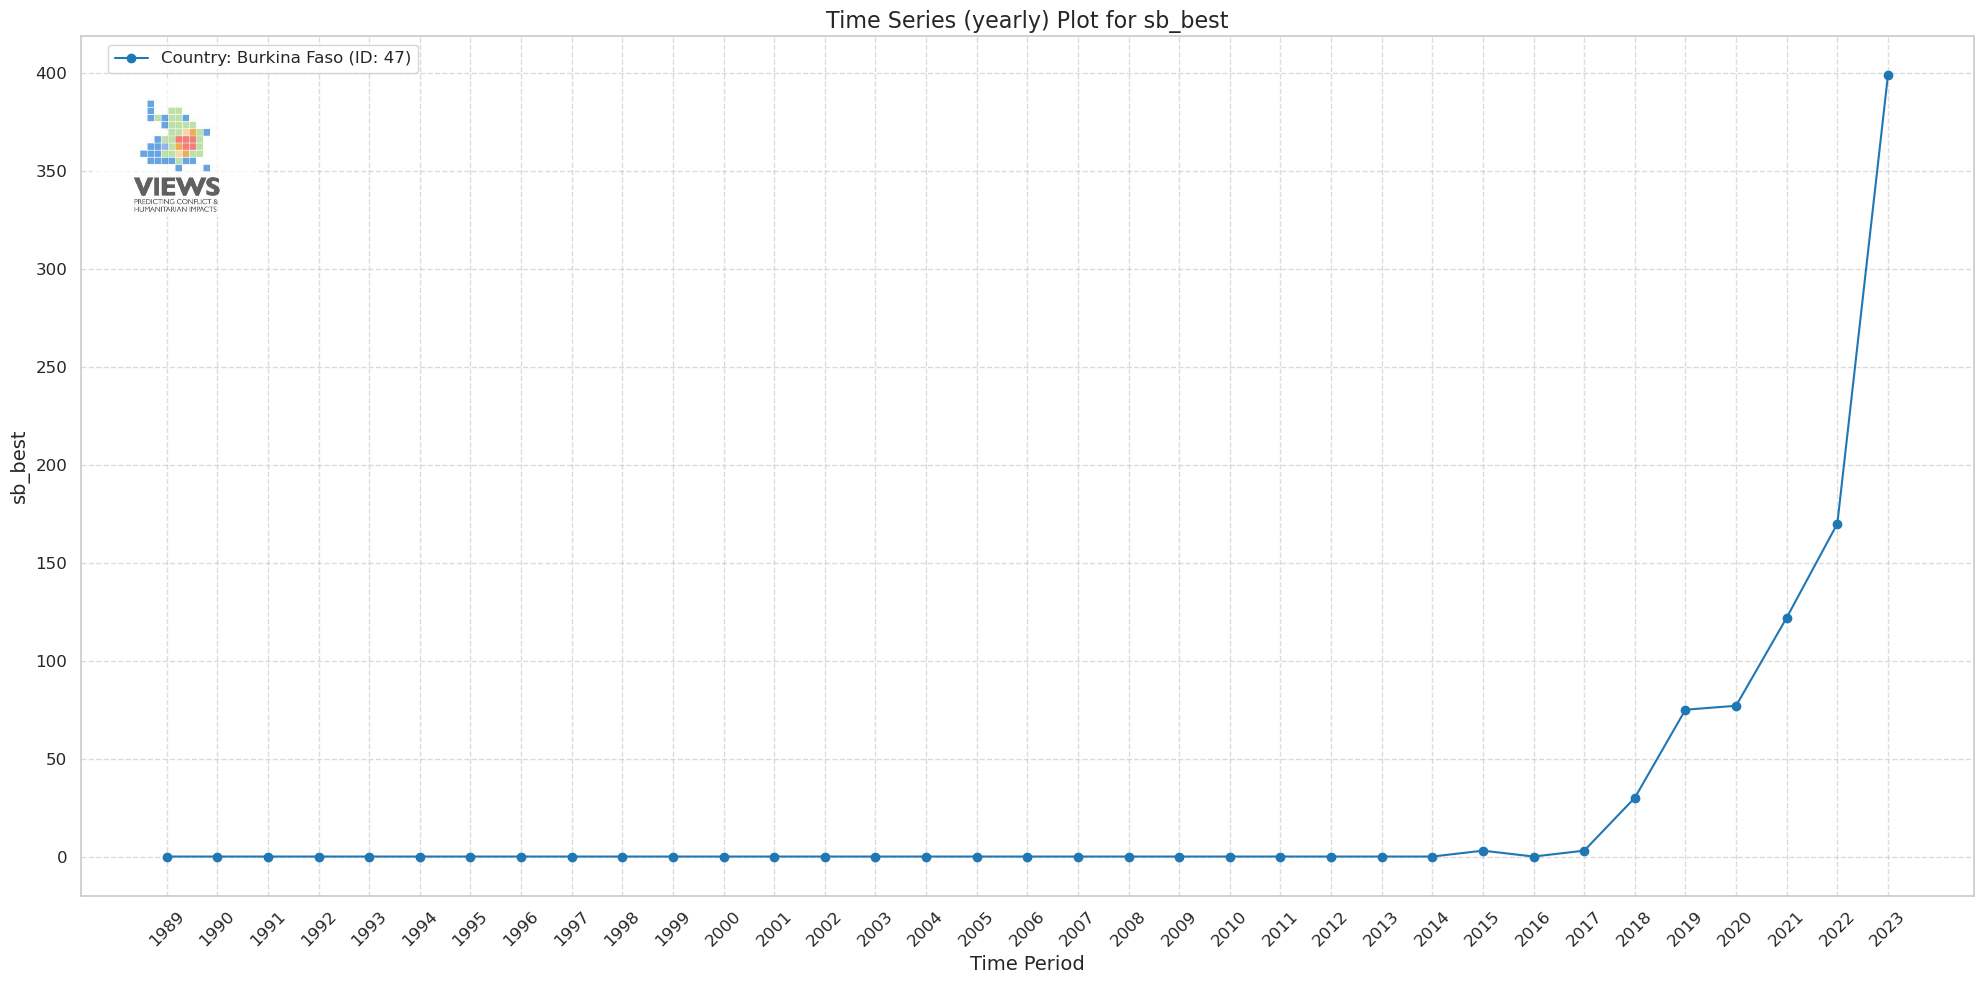

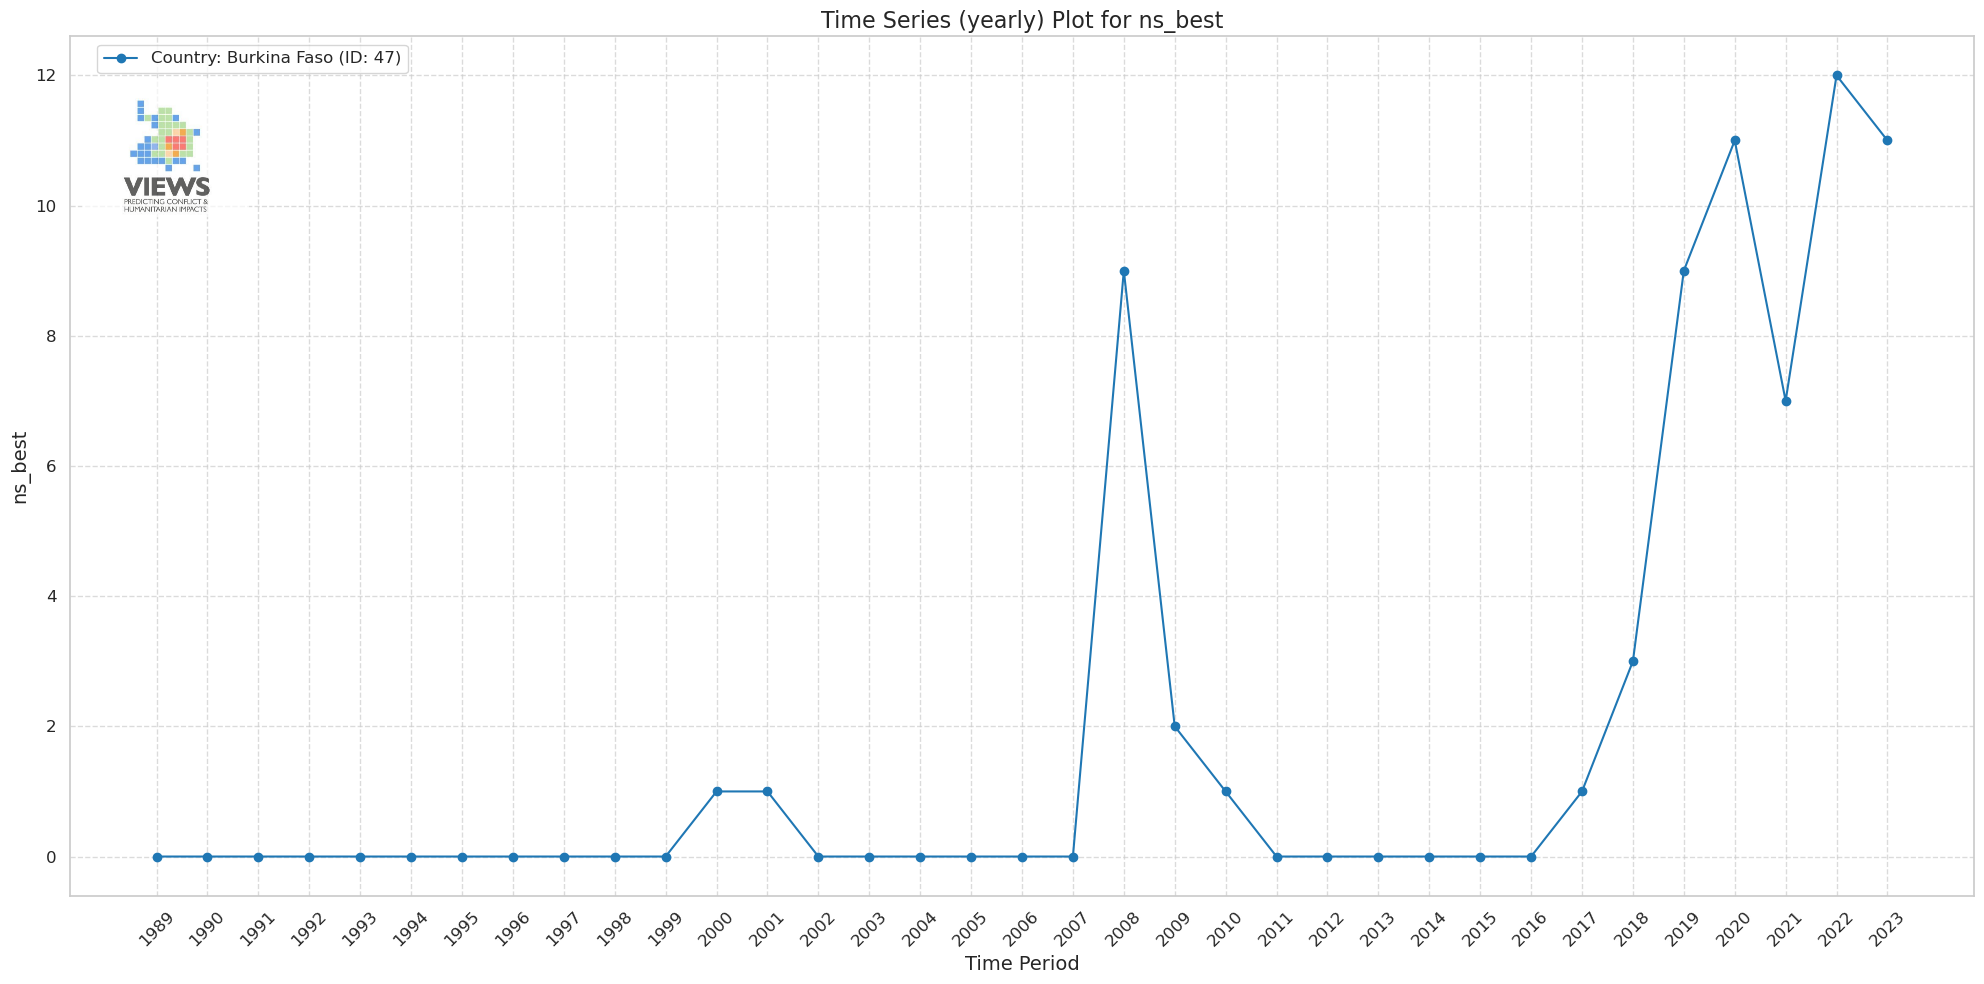

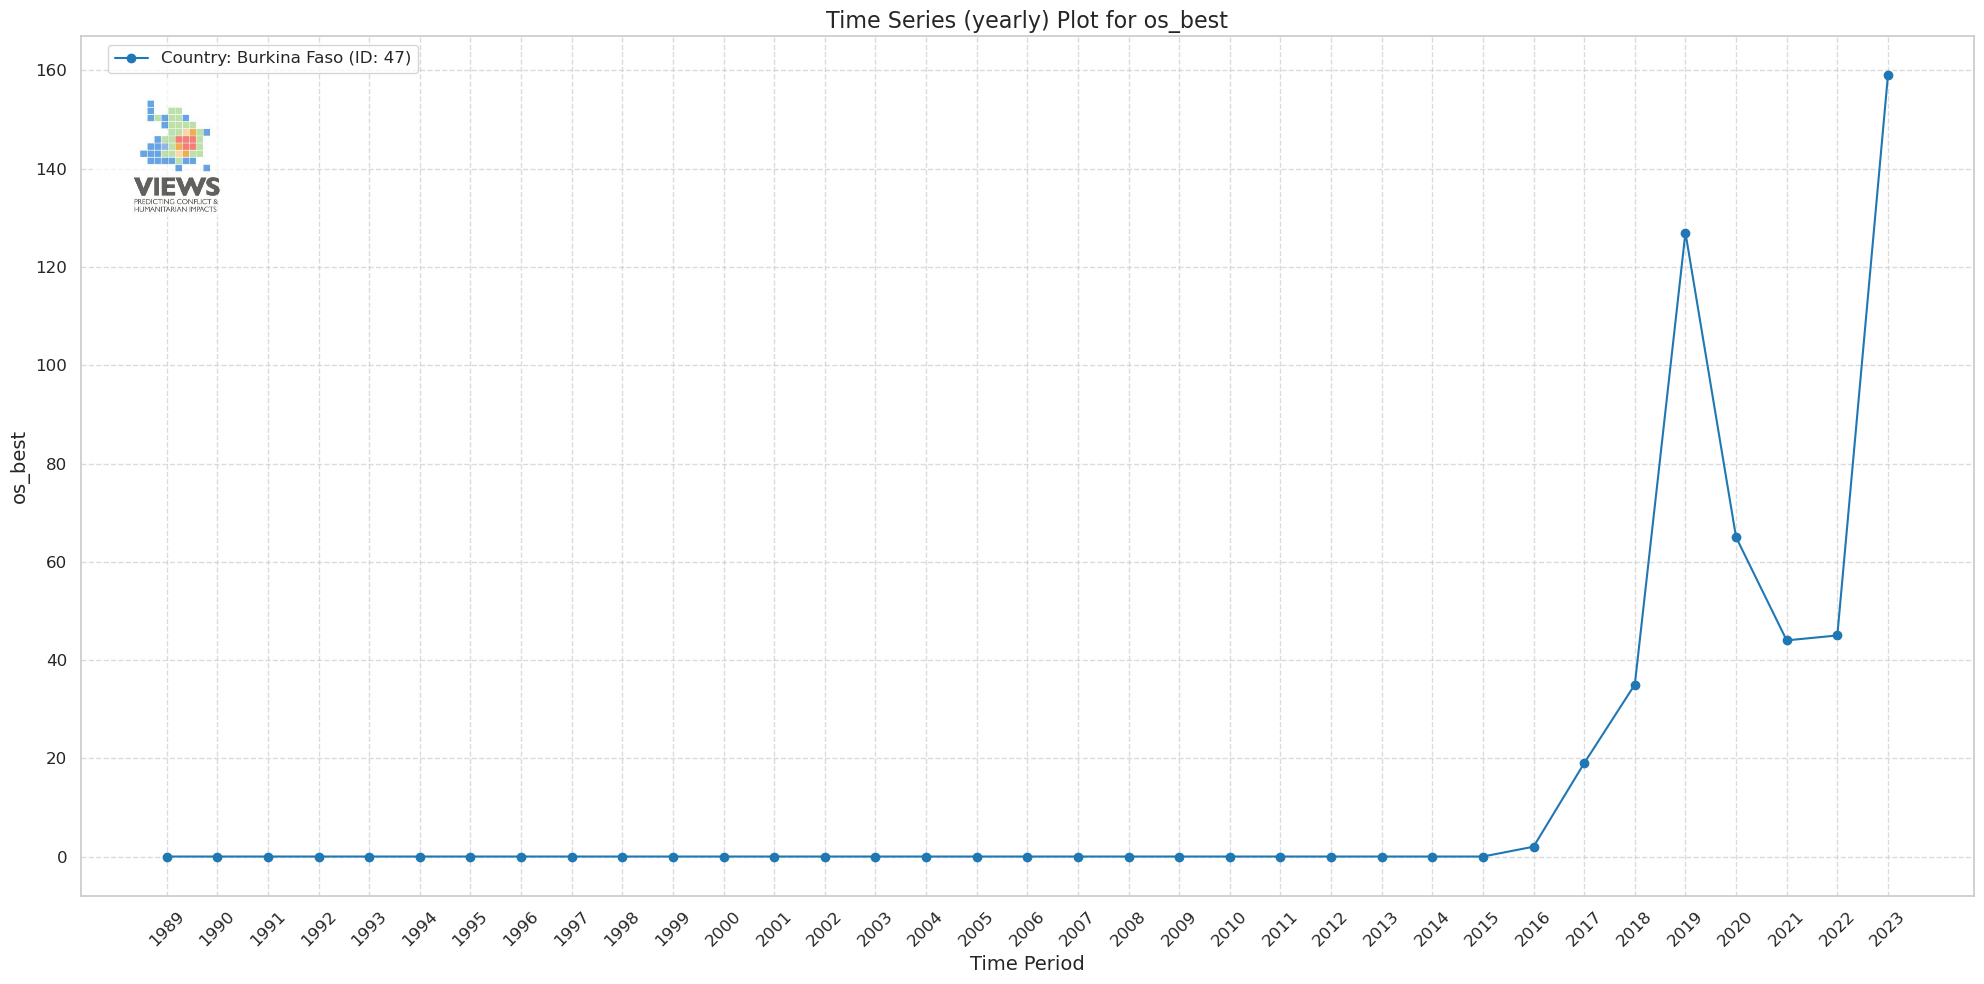

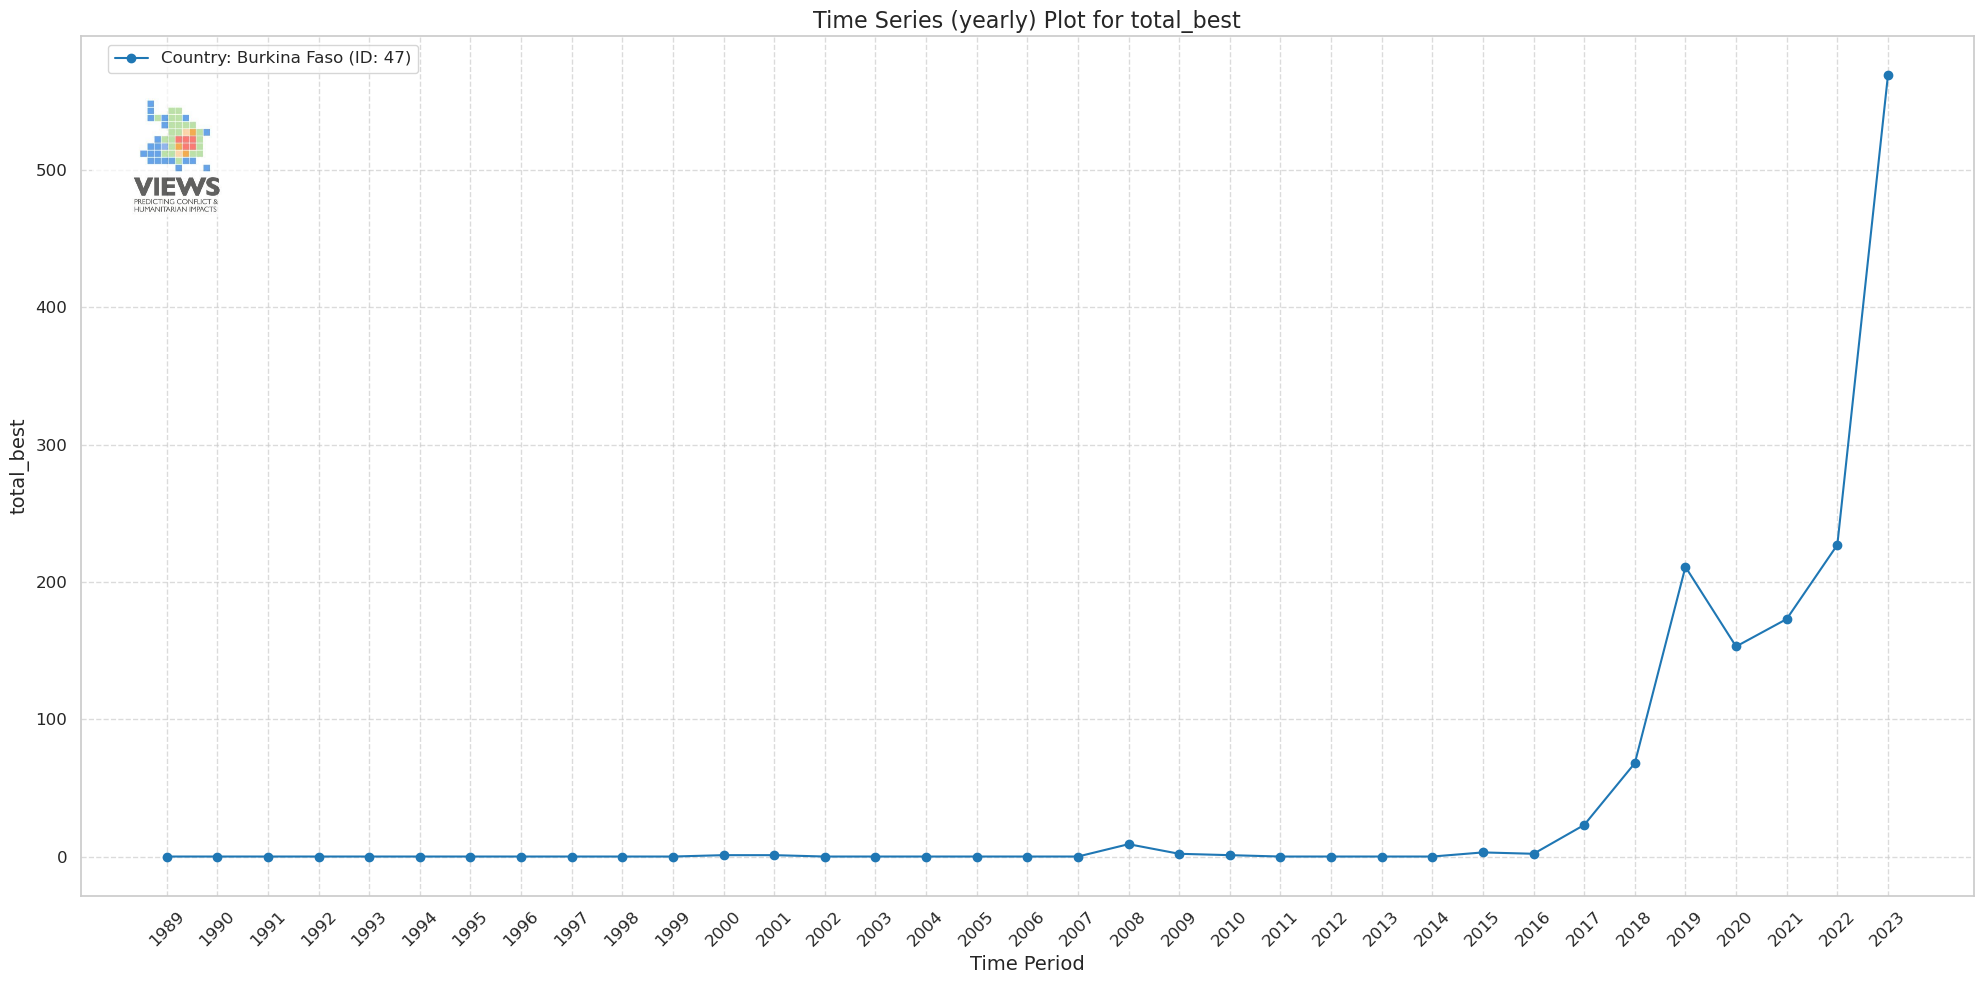

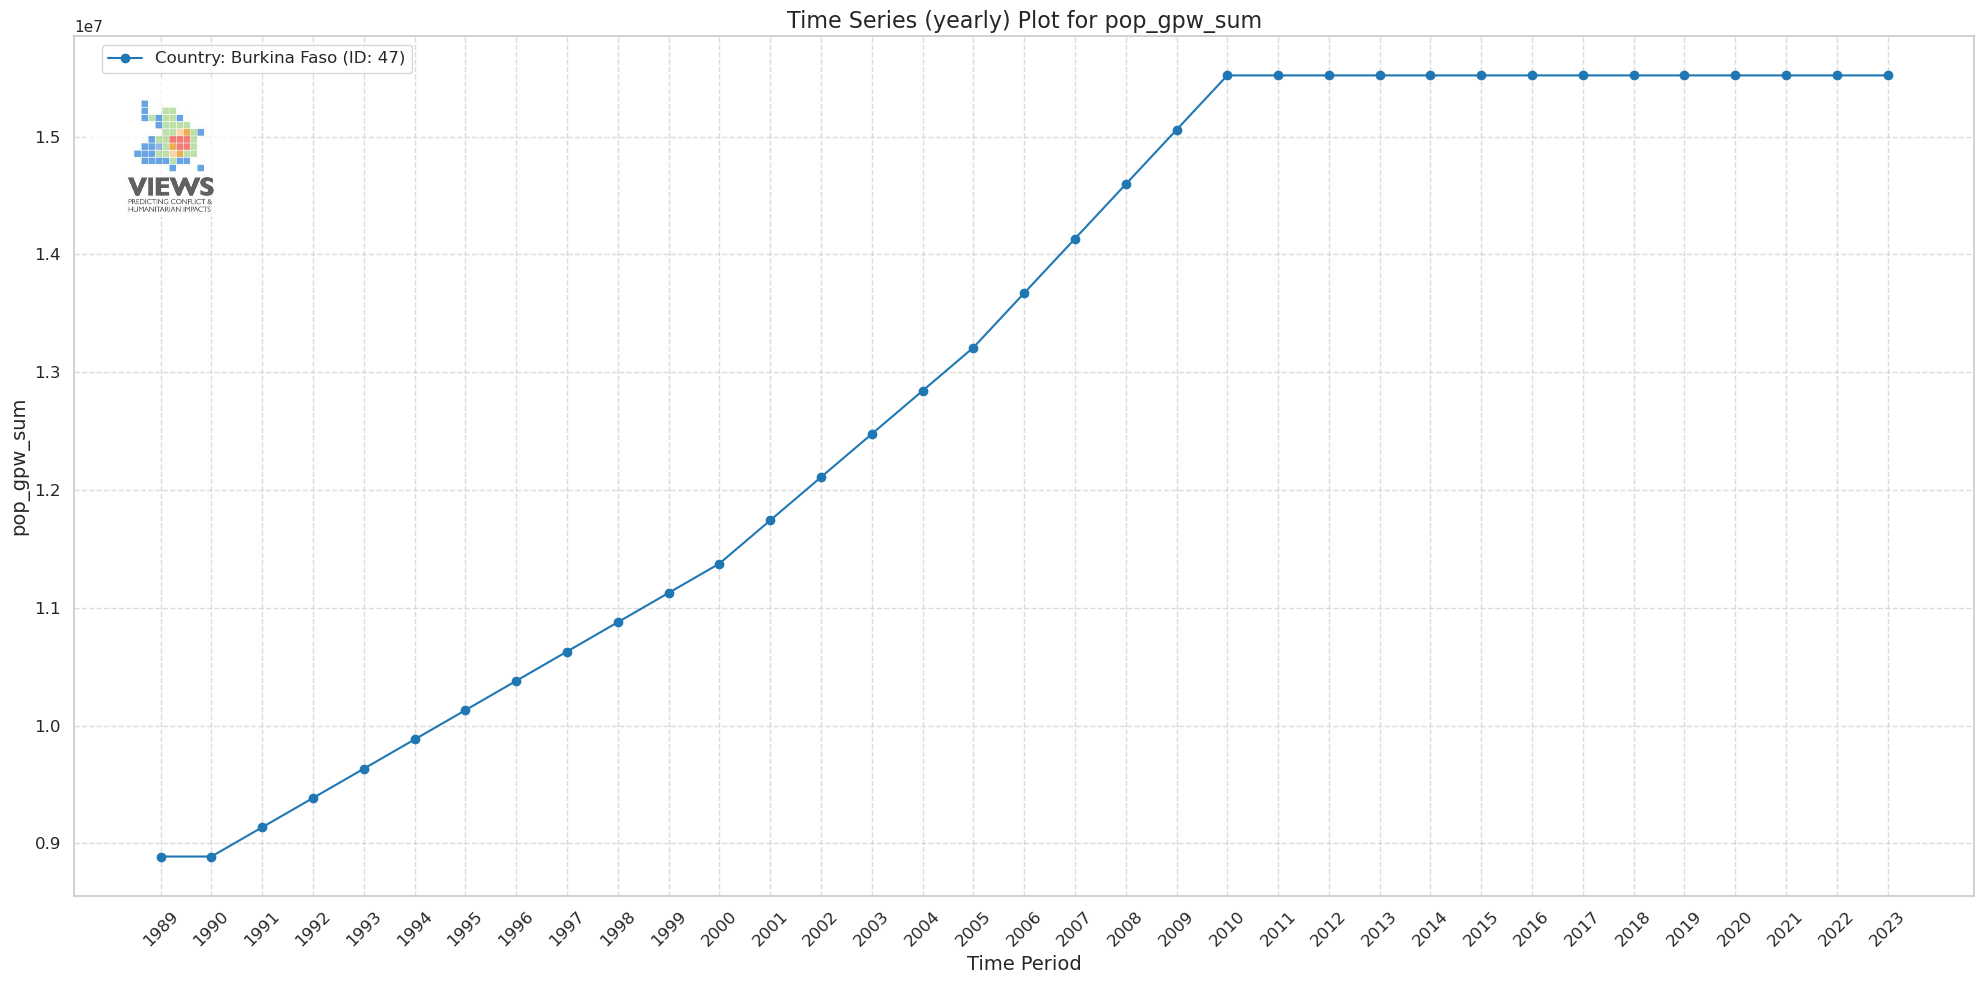

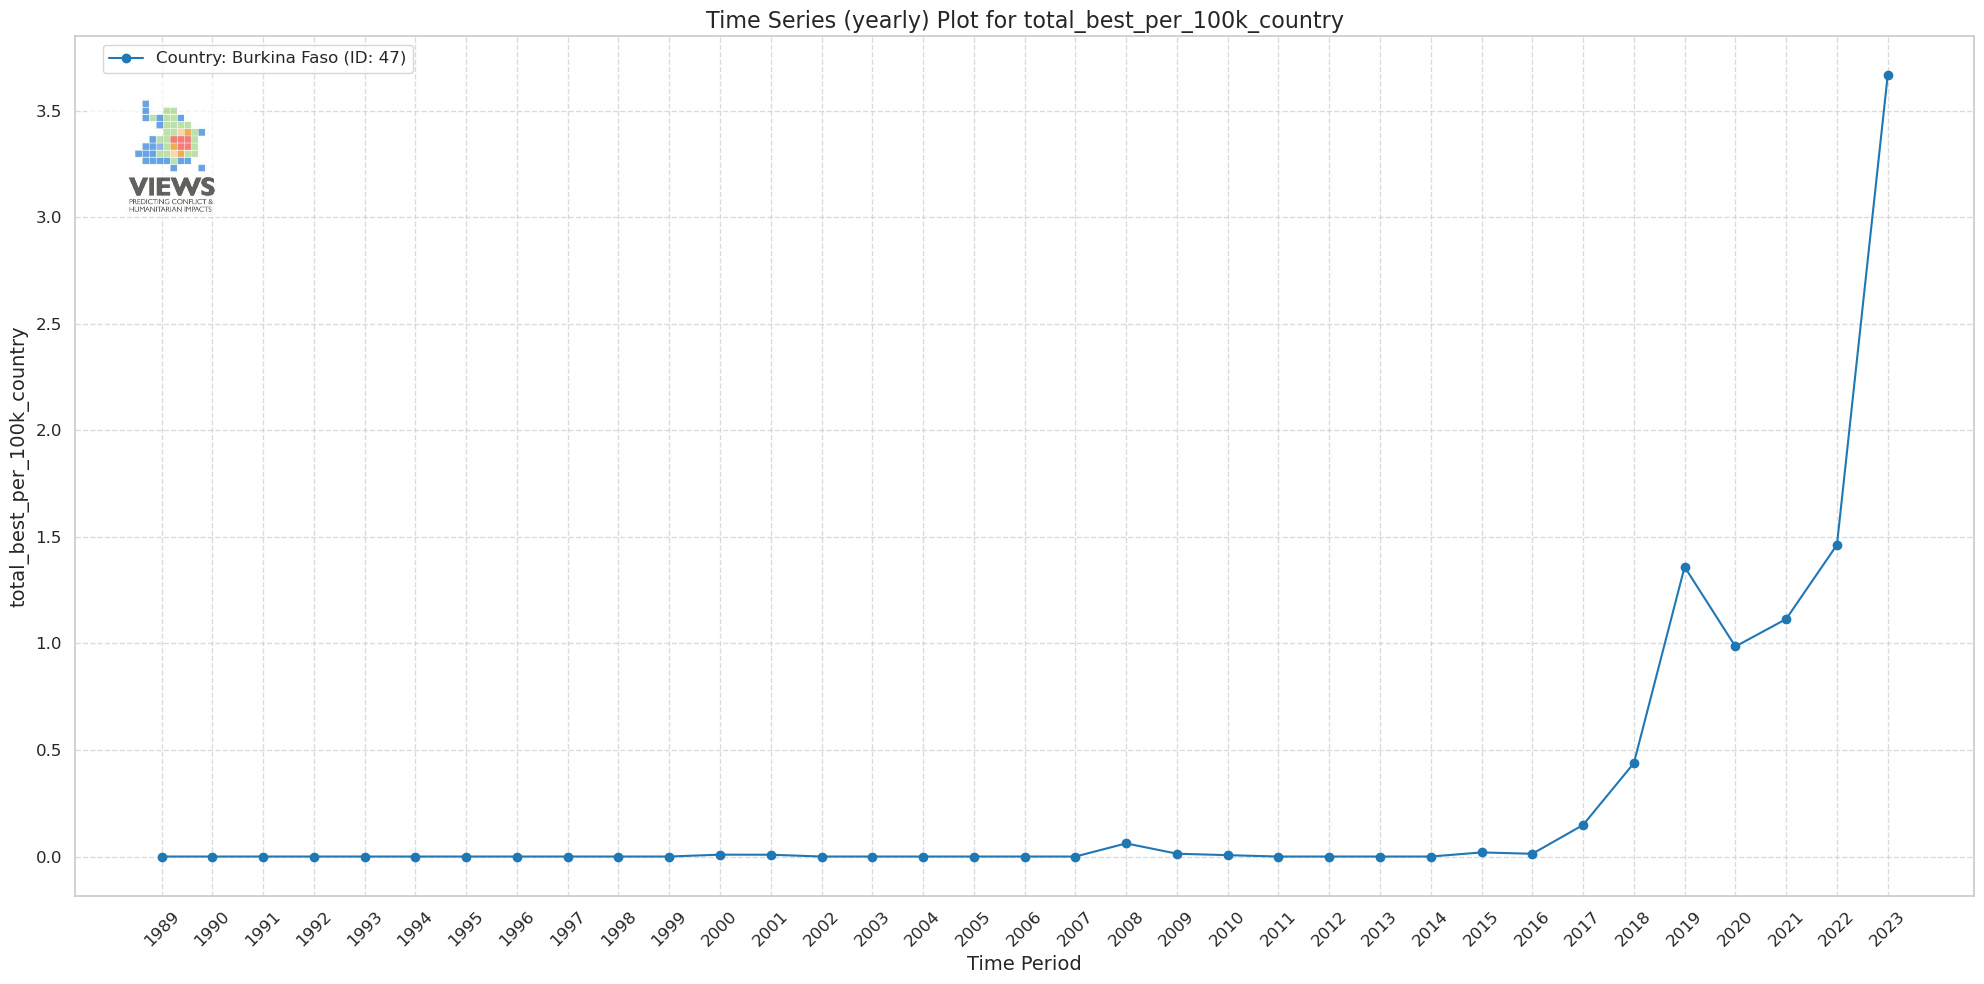

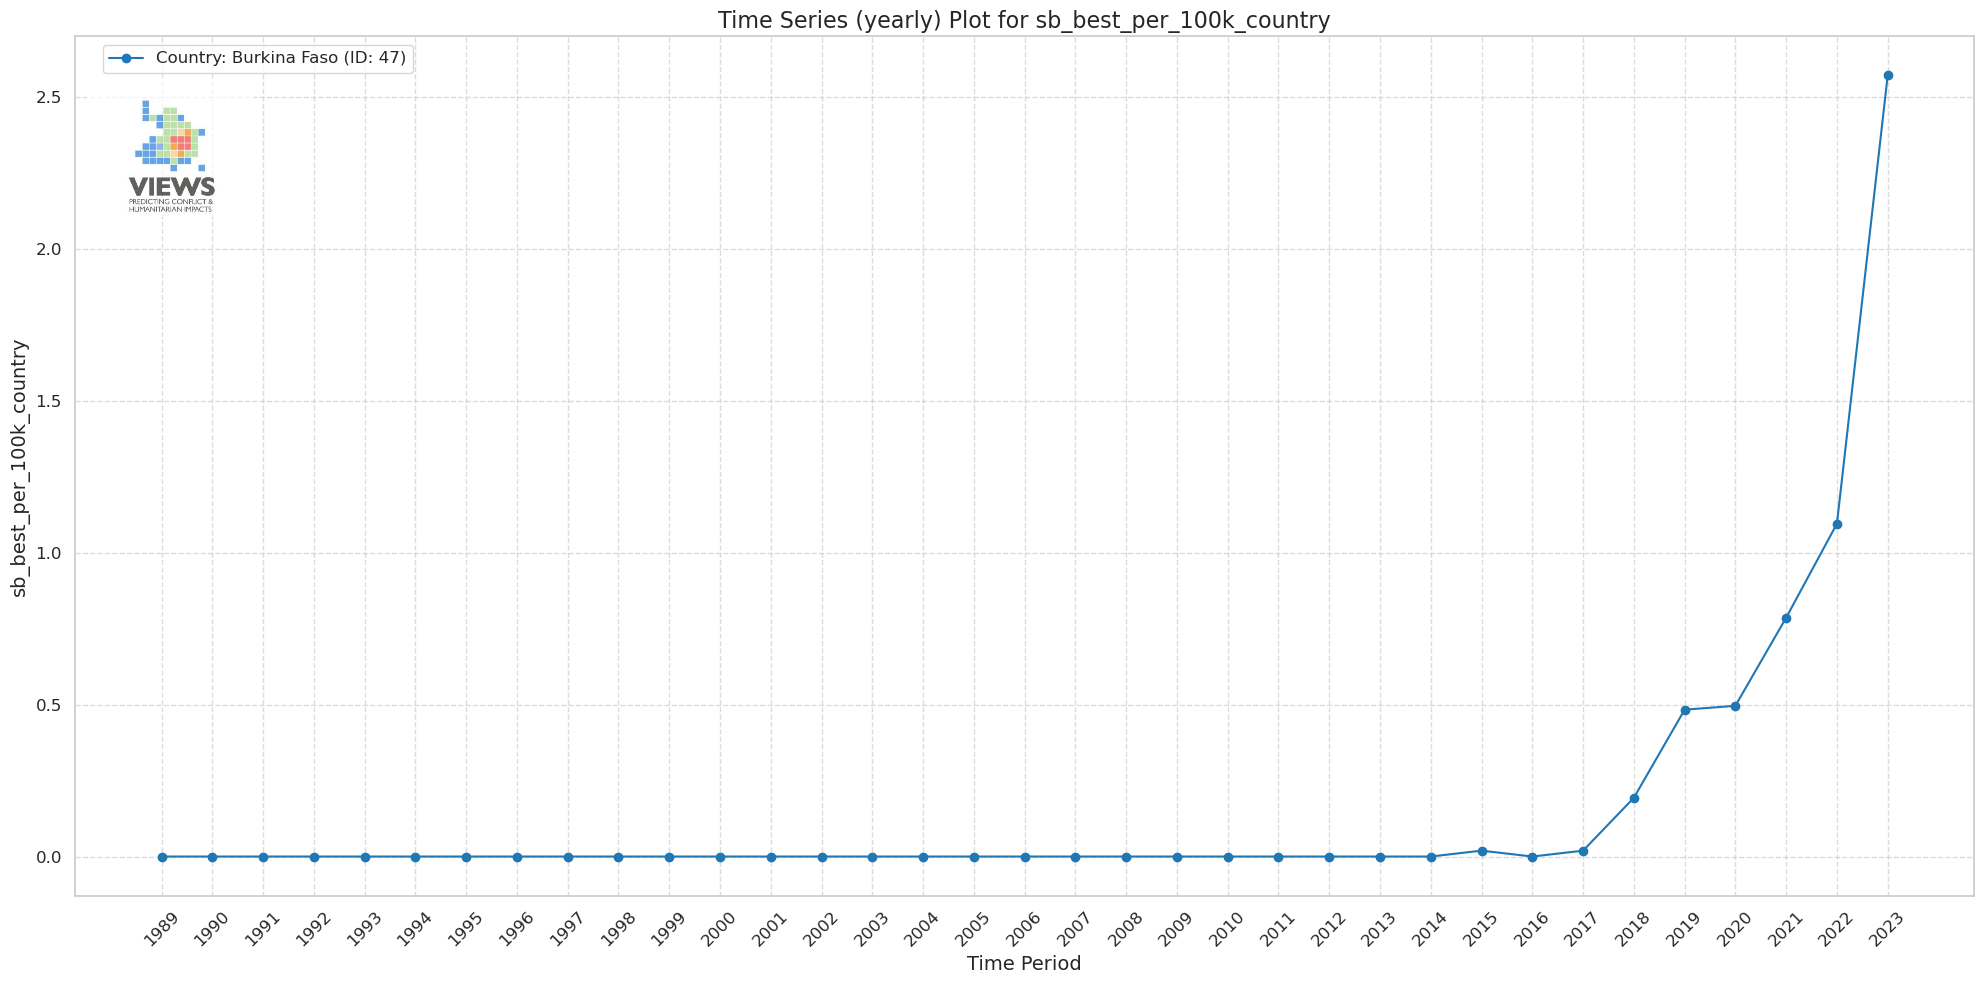

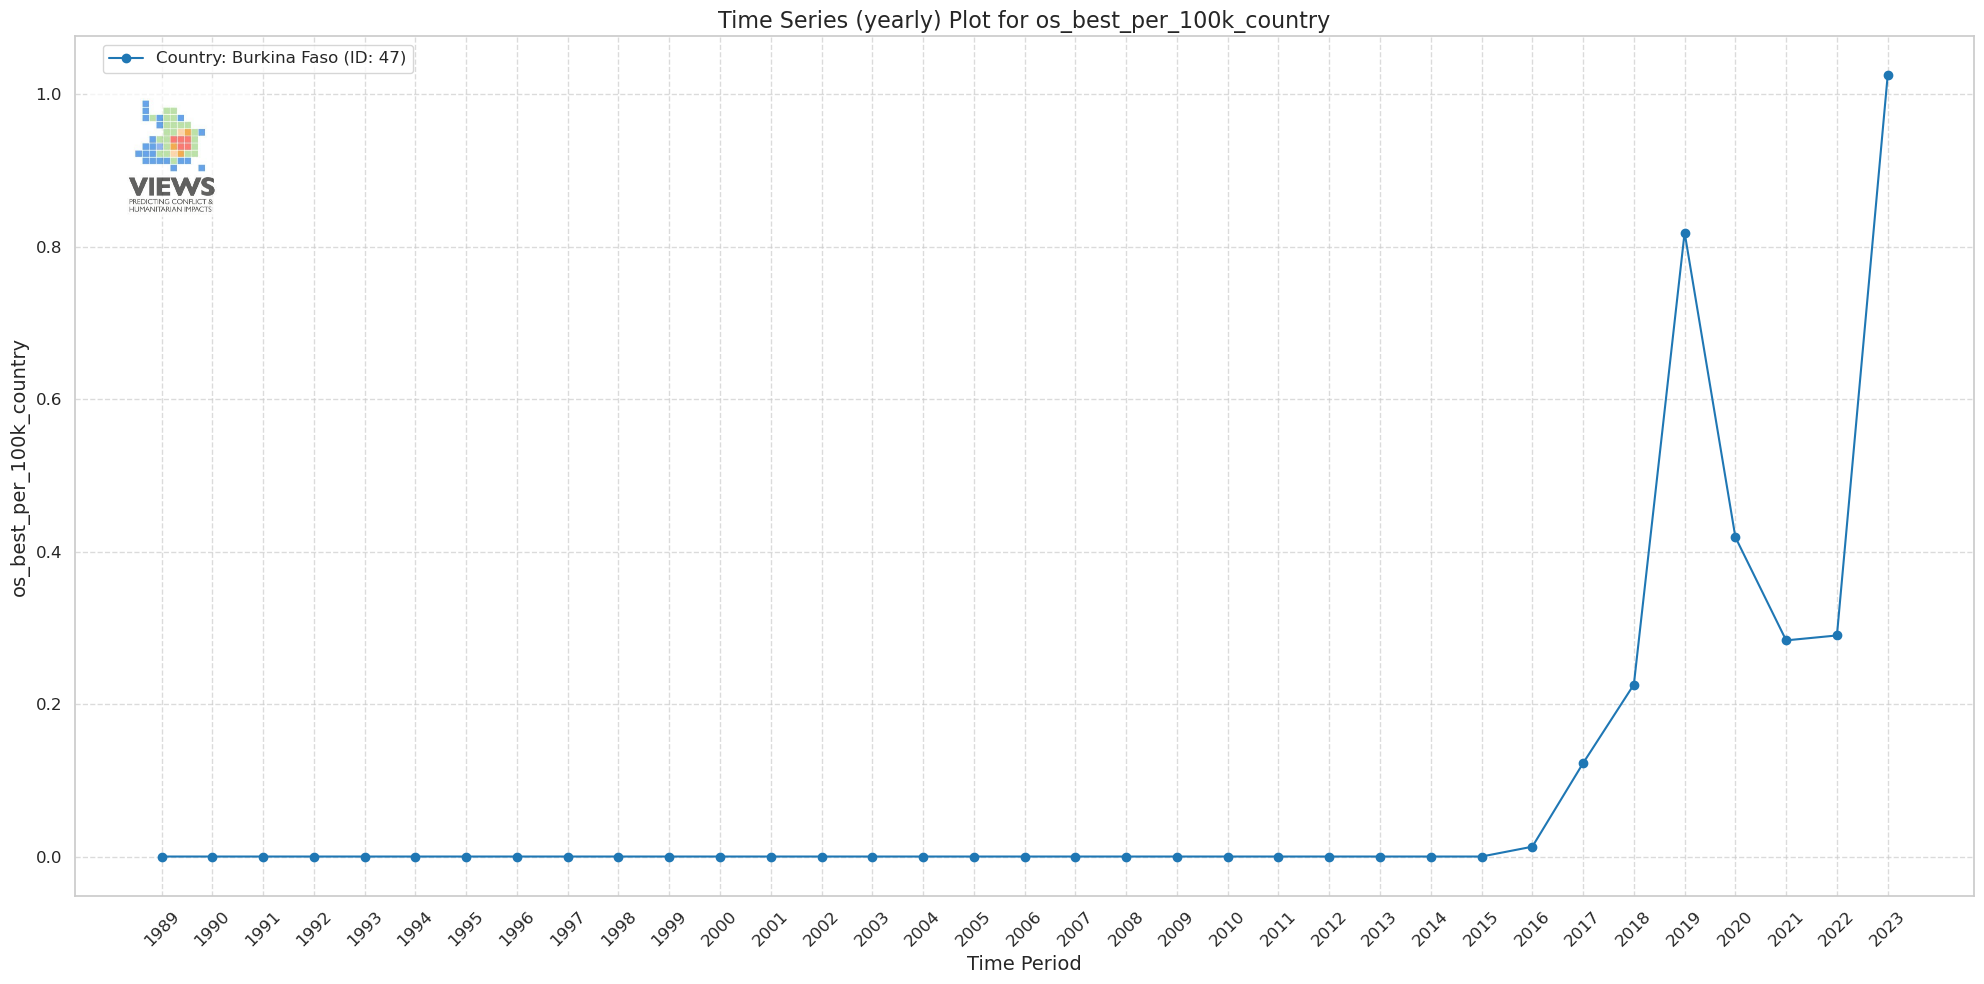

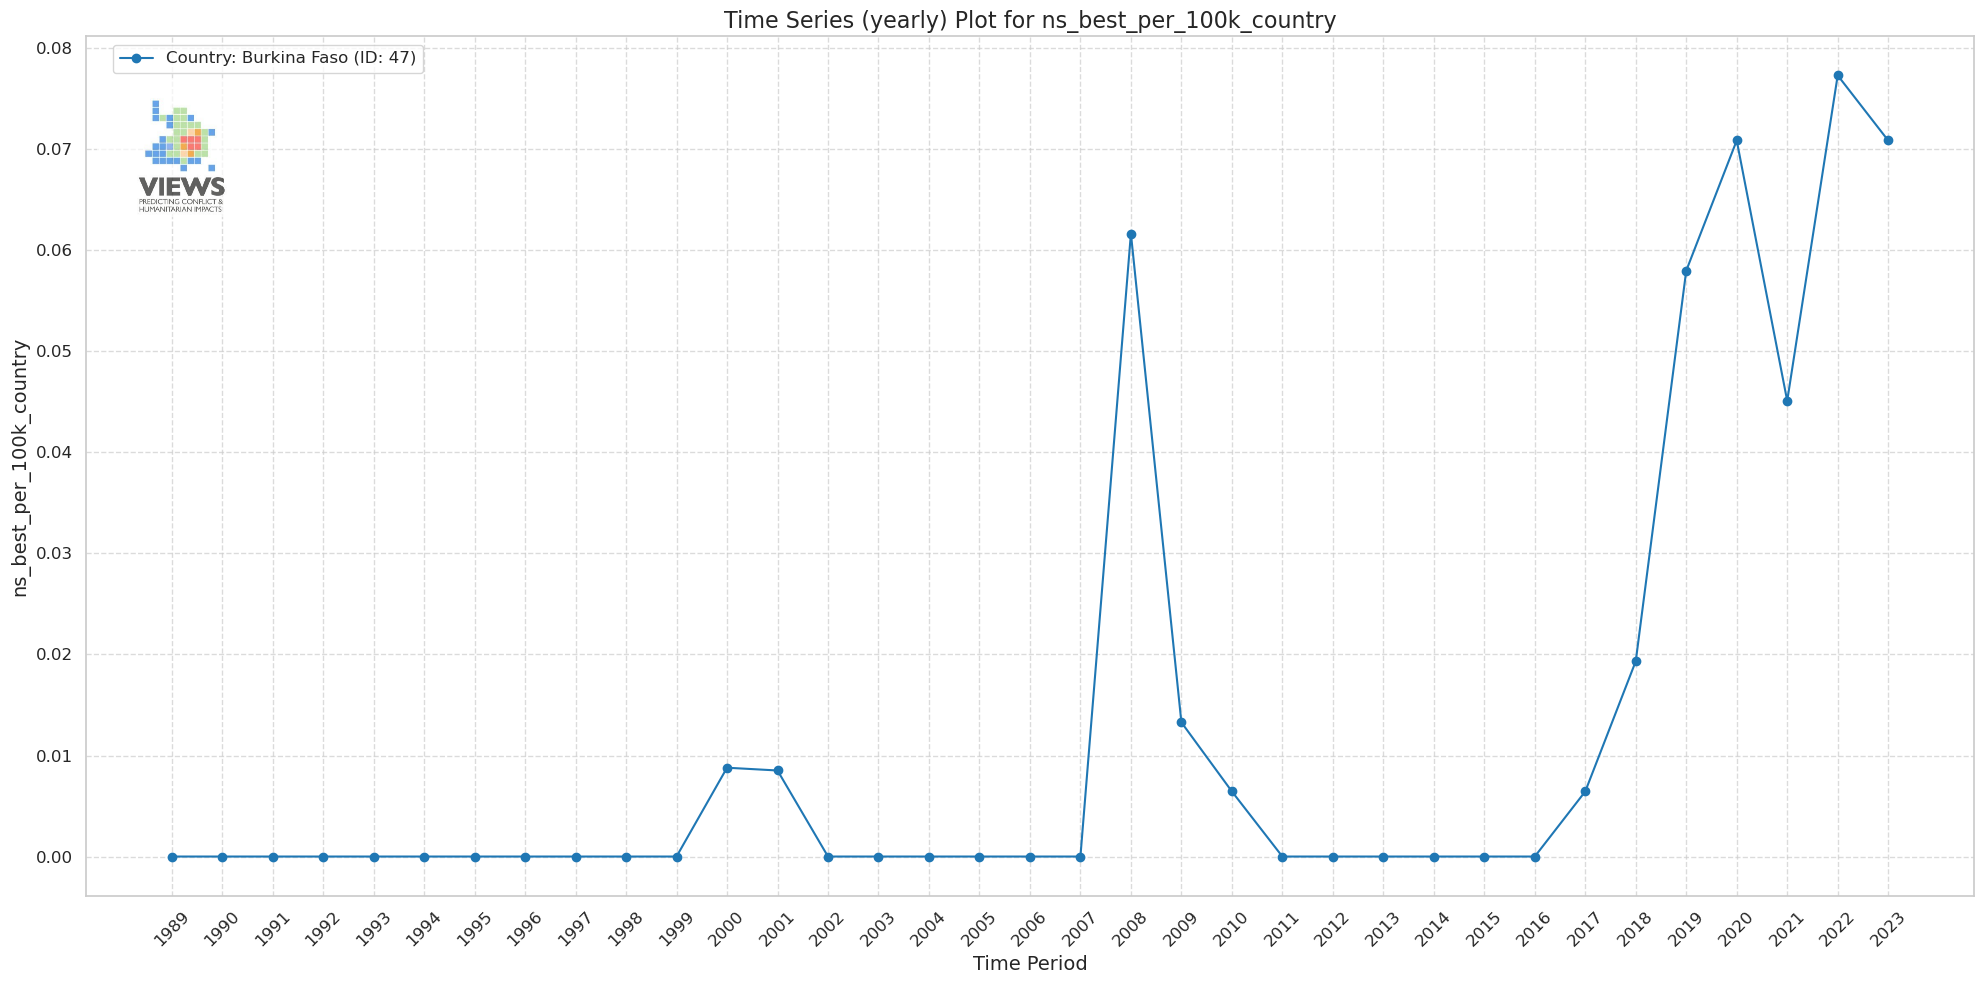

In [20]:
for feature in features:
    plot_country_time_series(df_yearly, [47], feature, figsize=(20, 10), logo_placement = (0.05, 0.87), legend_placement=(0.01, 1))

# OLD Shit below

In [ ]:
def calculate_burkina_faso_stats(df_monthly, month_id, c_id, features = ['total_best','sb_best', 'os_best', 'ns_best'], n_pop=100000):

    time_period = get_time_period(df_monthly)

    
    # First section: Monthly data for Burkina Faso (c_id = 47) in January 2023
    sum_monthly_jan_2023_pop_bf = df_monthly[(df_monthly['c_id'] == c_id) & (df_monthly[time_period] == month_id)]['pop_gpw_sum'].sum()
    print(sum_monthly_jan_2023_pop_bf)

    sum_monthly_jan_2023_fatalities_bf = df_monthly[(df_monthly['c_id'] == c_id) & (df_monthly[time_period] == month_id)]['total_best'].sum()
    print(sum_monthly_jan_2023_fatalities_bf)

    fatalities_per_100k_country = (sum_monthly_jan_2023_fatalities_bf / sum_monthly_jan_2023_pop_bf) * n_pop
    print(fatalities_per_100k_country)

    # ----------------------------

    df_test = df_monthly.copy()

    # Country, year, and month specific population normalization
    country_year_month_pop = df_test.groupby(['c_id', time_period])['pop_gpw_sum'].transform('sum')

    for feature in features:
        country_month_feature = df_test.groupby(['c_id', time_period])[feature].transform('sum')
        df_test[f"{feature}_per_100k_country_year_month"] = (country_month_feature / country_year_month_pop) * n_pop


    exemple_c_ids = [47, 57, 237, 161, 50, 244, 162, 78, 120, 242, 235, 124, 158]

    for e_c_id in exemple_c_ids:

        # get the periods for the c_id
        all_periods = df_test[df_test['c_id'] == e_c_id][time_period].unique()

        for period in all_periods:

            sum_monthly_jan_2023_pop_bf = df_monthly[(df_monthly['c_id'] == e_c_id) & (df_monthly[time_period] == period)]['pop_gpw_sum'].sum()
            #print(sum_monthly_jan_2023_pop_bf)

            sum_monthly_jan_2023_fatalities_bf = df_monthly[(df_monthly['c_id'] == e_c_id) & (df_monthly[time_period] == period)]['total_best'].sum()
            #print(sum_monthly_jan_2023_fatalities_bf)

            fatalities_per_100k_country = (sum_monthly_jan_2023_fatalities_bf / sum_monthly_jan_2023_pop_bf) * n_pop
            #print(fatalities_per_100k_country)


            exemple = df_test[(df_test['c_id'] == e_c_id) & (df_test[time_period] == period)]['total_best_per_100k_country_year_month'].unique()

            #print(exemple)

            # check if there is any nans, inf or -inf in the exemple
            if np.isnan(exemple).any() or np.isinf(exemple).any() or np.isneginf(exemple).any():
                print(f"Error: {e_c_id} - {period}")
            
            # if there is no element in the list
            if len(exemple) == 0:
                print(f"Error: {e_c_id} - {period}")

            if exemple[0] != fatalities_per_100k_country:
                print(f"Error: {e_c_id} - {period}")
                print(fatalities_per_100k_country)
                print(exemple)

            #print(exemple[0] == fatalities_per_100k_country)

            #print("\n")

# Example usage:
calculate_burkina_faso_stats(df_monthly, 337, 47)

In [ ]:
features = ['total_best', 'sb_best', 'ns_best', 'os_best']

def get_per_100k_country(df, features):

# ----------------------------
    n_pop = 100000
    time_period = get_time_period(df)

    # Country, year, and month specific population normalization
    country_pop = df.groupby(['c_id', time_period])['pop_gpw_sum'].transform('sum')

    for feature in features:
        country_feature = df.groupby(['c_id', time_period])['total_best'].transform('sum')
        feature_per_100k_country = (country_feature / country_pop) * n_pop
        df[f'{feature}_per_100k_country'] = feature_per_100k_country

     # test
    test_c_ids = [47, 57, 237, 161, 50, 244, 162, 78, 120, 242, 235, 124, 158]
    test_time_periods = df[time_period].unique()

    for c_id in test_c_ids:
        for t in test_time_periods:
            for feature in features:
                unique_feature_per_100k = df[(df['c_id'] == c_id) & (df[time_period] == t)][f'{feature}_per_100k_country'].unique()
                total_feature_sum = df[(df['c_id'] == c_id) & (df[time_period] == t)][feature].sum()

                if total_feature_sum > 0:
                    print(total_feature_sum)

                # check if unique_feature_per_100k is longer than 1
                if len(unique_feature_per_100k) > 1:
                    raise ValueError(f'unique_feature_per_100k is longer than 1: c_id: {c_id}, time_period: {t}, feature: {feature}, unique_feature_per_100k: {unique_feature_per_100k}, total_feature_sum: {total_feature_sum}')

                # check if unique_feature_per_100k is not empty and equal to total_feature_sum
                if len(unique_feature_per_100k) == 0 or unique_feature_per_100k[0] != total_feature_sum[0]:
                    # Uncomment the raise statement if you want to raise an error
                    # raise ValueError(f'unique_feature_per_100k is not equal to total_feature_sum: c_id: {c_id}, time_period: {t}, feature: {feature}, unique_feature_per_100k: {unique_feature_per_100k}, total_feature_sum: {total_feature_sum}')
                    print(f'unique_feature_per_100k is not equal to total_feature_sum: c_id: {c_id}, time_period: {t}, feature: {feature}, unique_feature_per_100k: {unique_feature_per_100k}, total_feature_sum: {total_feature_sum}')
    return df


In [ ]:
new_df_monthly = get_per_100k_country(df_monthly, features)

In [ ]:
df_test = df_monthly.copy()

n_pop = 100000

# contry specific population normalization
country_pop = df_test.groupby('c_id')['pop_gpw_sum'].transform('sum')
country_total_best = df_test.groupby('c_id')['total_best'].transform('sum')
country_sb_best = df_test.groupby('c_id')['sb_best'].transform('sum')
country_ns_best = df_test.groupby('c_id')['ns_best'].transform('sum')

df_test['fatalities_per_100k_country'] = (country_total_best / country_pop) * n_pop
df_test['sb_per_100k_country'] = (country_sb_best / country_pop) * n_pop
df_test['ns_ter_100k_country'] = (country_ns_best / country_pop) * n_pop

In [ ]:
print(df_test[(df_test['c_id'] == 47) & (df_test['year_id'] == 2023)]['fatalities_per_100k_country'])

In [ ]:
print(df_monthly[(df_monthly['c_id'] == 47) & (df_monthly['year_id'] == 2023)].sum()['total_best'])

In [ ]:
plot_country_time_series(df_monthly, [47], 'fatalities_per_100k', figsize=(20, 10), logo_placement = (0.05, 0.87), legend_placement=(0.01, 1))

In [ ]:
print(df_monthly[(df_monthly['c_id'] == 47) & (df_monthly['year_id'] == 2023) & (df_monthly['month'] == 1)]['pop_gpw_sum'].sum())

In [ ]:
plot_country_time_series(df_monthly, [47], 'total_best', figsize=(20, 10), logo_placement = (0.05, 0.87), legend_placement=(0.01, 1))

In [ ]:
plot_country_time_series(df_monthly, [47], 'pop_gpw_sum', figsize=(20, 10), logo_placement = (0.05, 0.87), legend_placement=(0.01, 1))

In [ ]:
1.5e7

In [ ]:
get_country_id_by_name("burkina faso")

In [ ]:
country_list = [47, 57, 237, 161, 50, 244, 162, 78, 120, 242, 235, 124, 158]

In [ ]:
plot_country_time_series(df_yearly, country_list, 'pop_gpw_sum', figsize=(20, 10), logo_placement = (0.05, 0.87), legend_placement=(0.01, 1))

In [ ]:
plot_country_time_series(df_yearly, [47], 'sb_best', figsize=(20, 10), logo_placement = (0.05, 0.87), legend_placement=(0.01, 1))

In [ ]:
plot_country_time_series(df_yearly, [47], 'pop_gpw_sum', figsize=(20, 10), logo_placement = (0.05, 0.87), legend_placement=(0.01, 1))

In [ ]:
# turn scineticfic into float
1.6e7


In [ ]:
plot_country_time_series(df_monthly, [47], 'total_best', figsize=(20, 10), logo_placement = (0.05, 0.87), legend_placement=(0.01, 1))

In [ ]:
plot_country_time_series(df_yearly_global_country_level, [47], '_per_100k', figsize=(20, 10), logo_placement = (0.05, 0.87), legend_placement=(0.01, 1))

In [ ]:
get_country_id_by_name("Malawi")

In [ ]:
plot_country_time_series(df_monthly_global_country_level, [47], 'pop_gpw_sum', figsize=(20, 10), logo_placement = (0.05, 0.87), legend_placement=(0.01, 1))

In [ ]:
plot_country_time_series(df_monthly, [47], 'pop_gpw_sum', figsize=(20, 10), logo_placement = (0.05, 0.87), legend_placement=(0.01, 1))

In [ ]:
plot_country_time_series(df_yearly, [47], 'pop_gpw_sum', figsize=(20, 10), logo_placement = (0.05, 0.87), legend_placement=(0.01, 1))

In [ ]:
plot_country_time_series(df_yearly_global_country_level, [id], 'sb_best', figsize=(20, 10), logo_placement = (0.05, 0.87), legend_placement=(0.01, 1), force_color = color)

In [ ]:

def plot_features_grid(df, feature_list, period_range, period_specific_min_max=False):
    """
    
    """

    fig, axs = plt.subplots(len(period_range), len(feature_list), figsize=(25, 5 * len(period_range)))

    time_peirod = get_time_period(df)

    if time_peirod == 'month_id':
        # check that the range is between 100 and 600 or raise an error
        min_month_id = df['month_id'].min()
        max_month_id = df['month_id'].max()
        if not all(min_month_id <= period <= max_month_id for period in period_range):
            raise ValueError(f'Monthly time period: Period range should be between {min_month_id} and {max_month_id}')
    elif time_peirod == 'year_id':
        # check that the range is between 1980 and 2020 or raise an error'
        min_year_id = df['year_id'].min()
        max_year_id = df['year_id'].max()
        if not all(min_year_id <= period <= max_year_id for period in period_range):
            raise ValueError(f'Yearly time period: Period range should be between {min_year_id} and {max_year_id}')

    for row_idx, period in enumerate(period_range):

        for col_idx, feature_name in enumerate(feature_list):

            # Determine colormap and value range
            if 'P_i' in feature_name or 'p_i' in feature_name:
                cmap = 'rainbow_r'
                vmin = 0
                vmax = 1
            else:
                cmap = 'rainbow'

                if period_specific_min_max:
              
                    # alt where the min and max are period specific
                    vmin = df[df[time_peirod] == period][feature_name].min()
                    vmax = df[df[time_peirod] == period][feature_name].max()

                else:
                    # alt where the min and max are global
                    vmin = df[feature_name].min()
                    vmax = df[feature_name].max()

            # Extract the data for the specific month_id
            period_data = df[df[time_peirod] == period]

            # Calculate the grid size based on min and max row and col values
            min_row = int(period_data['row'].min())
            max_row = int(period_data['row'].max())
            min_col = int(period_data['col'].min())
            max_col = int(period_data['col'].max())

            # Create the grid with adjusted size
            grid_rows = max_row - min_row + 1
            grid_cols = max_col - min_col + 1
            grid = np.full((grid_rows, grid_cols), np.nan)

            # Fill the grid with the feature_name values, adjusting for min_row and min_col
            for _, row in period_data.iterrows():
                grid[int(row['row']) - min_row, int(row['col']) - min_col] = row[feature_name]

            # Plot with imshow
            cax = axs[row_idx, col_idx].imshow(grid, cmap=cmap, vmin=vmin, vmax=vmax, origin='lower', aspect='auto', interpolation='none')
            fig.colorbar(cax, ax=axs[row_idx, col_idx], orientation='vertical', label=feature_name)

    plt.tight_layout()
    plt.show()

# Example usage:
# plot_features_grid(new_df, 'some_feature')

In [ ]:
print(df_yearly.columns)
print(get_country_names_by_ids([119]))

In [ ]:
get_time_period(df_yearly)

In [ ]:
feature = 'fatalities_per_100k'

In [ ]:
def process_data_country_wise_posttest(df, feature):
    """
    Processes the data for a given country by performing post-test checks.

    Parameters:
    - df (pd.DataFrame): Input dataframe containing the data.
    - feature (str): The feature column to be processed.

    Returns:
    - bool: True if all checks pass, otherwise raises a ValueError.

    Raises:
    - ValueError: If the input is not a pandas DataFrame.
    - ValueError: If the DataFrame is empty.
    - ValueError: If the DataFrame contains NaN values.
    - ValueError: If the DataFrame contains infinite values.
    - ValueError: If any column contains only one unique value.
    """
    
    # check that the df is a pandas dataframe
    if not isinstance(df, pd.DataFrame):
        raise ValueError('Input should be a pandas DataFrame')
    
    # check that the df is not empty
    if df.empty:
        raise ValueError('DataFrame is empty')
    
    # check that it does not contain NaN or inf values
    if df.isnull().values.any():
        raise ValueError('DataFrame contains NaN values')
    
    if np.isinf(df.values).any():
        raise ValueError('DataFrame contains infinite values')
    
    # check that no columns only contain one unique value
    for column in df.columns:
        if len(df[column].unique()) == 1:
            unique_value = df[column].unique()[0]
            raise ValueError(f'Column {column} only contains one unique value {unique_value}')
    
    return True

In [ ]:
df_yearly_global_country_level = process_data_country_wise(df_yearly, 'fatalities_per_100k')

In [ ]:
df_yearly_global_country_level.head()

In [ ]:
 #check that the timelin plot is still cool.
plot_country_time_series(df_yearly_global_country_level, [50], 'fatalities_per_100k', figsize=(20, 10), logo_placement = (0.05, 0.87), legend_placement=(0.01, 1))

In [ ]:
df_monthly_global_country_level = process_data_country_wise(df_monthly, 'fatalities_per_100k')

In [ ]:
df_monthly_global_country_level.head()

In [ ]:
# try to plot the time series for monthly mali  (50)
plot_country_time_series(df_monthly_global_country_level, [50, 43, 222], 'fatalities_per_100k', figsize=(20, 10), logo_placement = (0.05, 0.87), legend_placement=(0.01, 1))

In [ ]:
df_monthly_global_country_level.to_pickle(PATH_GENERATED / "df_monthly_country_return_periods.pkl")
df_monthly_global_country_level.to_csv(PATH_GENERATED / "df_monthly_country_return_periods.csv")

df_yearly_global_country_level.to_pickle(PATH_GENERATED / "df_yearly_country_return_periods.pkl")
df_yearly_global_country_level.to_csv(PATH_GENERATED / "df_yearly_country_return_periods.csv")

In [ ]:
get_country_id_by_name('yemen')

In [ ]:
plot_country_time_series(df_monthly_global_country_level, [124,240, 196,197], 'fatalities_per_100k', figsize=(20, 10), logo_placement = (0.05, 0.87), legend_placement=(0.01, 1))

# add b_i and B_i then plots

In [ ]:
def bin_series(series: pd.Series, bins: list) -> pd.Series:
    """
    Bins a pandas Series based on specified lower bounds.

    Parameters:
    ----------
    series : pd.Series
        The series containing the values to be binned.
    bins : list
        A list of lower bounds defining the bins. The last bin will automatically extend to infinity.

    Returns:
    -------
    pd.Series
        A new Series with values binned according to the specified intervals.

    Example:
    -------
    >>> s = pd.Series([1, 2, 3, 5, 7, 10, 15, 25, 35])
    >>> bins = [1, 2, 5, 10, 30]
    >>> bin_series(s, bins)
    0     1
    1     2
    2     2
    3     5
    4     5
    5    10
    6    10
    7    10
    8    30
    dtype: int64
    """

    # Extend bins to infinity
    extended_bins = bins + [np.inf]

    # Use the lower bounds as labels
    labels = bins

    # Bin the series
    binned_series = pd.cut(series, bins=extended_bins, labels=labels, right=False, include_lowest=True)

    return binned_series


In [ ]:
bin_list = [1, 3, 5, 10, 15, 20, 25, 30] # then also one for months... 
b_i = bin_series(df_yearly_global_country_level[f'{feature}_e_i'], bin_list)
b_i

In [ ]:
b_i

In [ ]:
plt.hist(b_i, bins=10)
plt.show()

so add b_i and B_i to the columns and then adapt the plot - move the binnign function to a script and then we are good. 

In [ ]:
# plot one country
country_id = 50
feature = 'fatalities_per_100k'
all_years = df_yearly_global_country_level['year_id'].unique()

feature_list = get_extended_feature_list(df_yearly_global_country_level, feature, base_feature = True, p_i = True, P_i = True, e_i = True, E_i = True, b_i = False, B_i = False)

plot_features_grid(df_yearly_global_country_level[df_yearly_global_country_level['c_id'] == country_id], feature_list, all_years[:10])

In [ ]:
all_years = df_yearly_global_country_level['year_id'].unique()
plot_features_grid(df_yearly_global_country_level, feature, all_years)


In [ ]:


new_df_monthly = update_df_with_probabilities_and_return_periods(df_monthly, feature, region_id_type, region_id)
new_df_yearly = update_df_with_probabilities_and_return_periods(df_yearly, feature, region_id_type, region_id)

In [ ]:
new_df_yearly.describe()

In [ ]:
# try with a country
country_name = 'Mali'
country_id = get_country_id_by_name(country_name)
print(country_id)

country_id = 50
region_id_type = 'c_ids' # pg_ids, c_ids, or global

new_df_monthly_mali = update_df_with_probabilities_and_return_periods(df_monthly, feature, region_id_type, country_id)
new_df_yearly_mali = update_df_with_probabilities_and_return_periods(df_yearly, feature, region_id_type, country_id)

new_df_monthly_mali.describe()
new_df_yearly_mali.describe()

In [ ]:
new_df_monthly_mali['month_id'].max()

In [ ]:
# check wivh month id have the event with the higsest E_i
new_df_monthly_mali[new_df_monthly_mali['fatalities_per_100k_E_i'] == new_df_monthly_mali['fatalities_per_100k_E_i'].max()]['month_id']

In [ ]:
new_df_yearly_mali

In [ ]:
plot_features_grid(new_df_yearly_mali, feature, period_range = np.arange(2020, 2024))

In [ ]:
# try with rwanda
country_name = 'Rwanda'
country_id = get_country_id_by_name(country_name)
print(country_id)
country_id = 156

new_df_monthly_rwanda = update_df_with_probabilities_and_return_periods(df_monthly, feature, region_id_type, country_id)
new_df_yearly_rwanda = update_df_with_probabilities_and_return_periods(df_yearly, feature, region_id_type, country_id)


In [ ]:
plot_features_grid(new_df_yearly_rwanda, feature, period_range = np.arange(1992, 1996))

In [ ]:
# what months see the highest E_i
high_month = new_df_monthly_rwanda[new_df_monthly_rwanda['fatalities_per_100k_E_i'] == new_df_monthly_rwanda['fatalities_per_100k_E_i'].max()]['month_id'].values[0]
print(high_month)
print(calculate_date_from_index(high_month))

#lest try ranwda with the monthly data
plot_features_grid(new_df_monthly_rwanda, feature, period_range = np.arange(high_month-5, high_month+5))

In [ ]:
# try "global" yearly 1992-1996
region_id_type = 'global'
region_id = None

new_df_monthly_global = update_df_with_probabilities_and_return_periods(df_monthly, feature, region_id_type, region_id)
new_df_yearly_global = update_df_with_probabilities_and_return_periods(df_yearly, feature, region_id_type, region_id)

plot_features_grid(new_df_yearly_global, feature, period_range = np.arange(1991, 2024))

In [ ]:
get_country_names_by_ids([50])

In [ ]:
# okay lets try and loop over all the countries and then merge the dataframes. Yearly data only for now

unique_country_ids = df_yearly['c_id'].unique()

# create an empty dataframe to store the results
df_yearly_global_country_level = pd.DataFrame()

for country_id in unique_country_ids:
    print(f'Processing country_id: {country_id}') #, country_name: {get_country_names_by_ids([country_id])}')

    try:
        new_df_yearly_country = update_df_with_probabilities_and_return_periods(df_yearly, feature, 'c_ids', country_id)
        df_yearly_global_country_level = pd.concat([df_yearly_global_country_level, new_df_yearly_country])

    except Exception as e:
        print(f'Error with {country_id}: {e}') #, country_name: {get_country_names_by_ids([country_id])}. Skipping...')



In [ ]:
df_yearly_global_country_level.describe()

In [ ]:
# now plot all the years for the whole world
plot_features_grid(df_yearly_global_country_level, feature, period_range = np.arange(1991, 2024))

In [ ]:
get_country_id_by_name('Malawi')

In [ ]:
df_yearly[df_yearly['c_id'] == 161].describe()